# Creating an End-To-End Dialogue System

In the last lab we want to create end-to-end dialogue systems, following on from the seq2seq MT labs you've done. Customer support apps and online helpdesks are among the places where conversational models can be used. Retrieval-based models, which produce predefined responses to questions of specific types, are often used to power these models. In this lab, the seq2seq model is used to build a generative model.

To begin, download the data and unzip them.

After that, let’s import some necessities.

In [1]:
!wget 'https://github.com/juntaoy/ECS7001_LAB_DATASETS/raw/refs/heads/main/CA_data.zip'
!unzip CA_data.zip -x __MACOSX/*

--2025-04-25 13:15:27--  https://github.com/juntaoy/ECS7001_LAB_DATASETS/raw/refs/heads/main/CA_data.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/juntaoy/ECS7001_LAB_DATASETS/refs/heads/main/CA_data.zip [following]
--2025-04-25 13:15:27--  https://raw.githubusercontent.com/juntaoy/ECS7001_LAB_DATASETS/refs/heads/main/CA_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 81802360 (78M) [application/zip]
Saving to: ‘CA_data.zip’

CA_data.zip         100%[===================>]  78.01M   336MB/s    in 0.2s    

2025-04-25 13:15:28 (336 MB/s) - ‘CA_data.zip’ saved [81802360/81802360]

Archive:  CA_data.zip
  inflating: final_pairs_v21.pkl     
  inflating: chameleons.pdf          
  inflating: glove.6B.50d.txt        
  inflating: movie_characters_metadata.txt  
  inflating: movie_conversations.txt  
  inflating: movie_lines.txt         
  inflating: movie_titles_metadata.txt  
  inflating: raw_script_urls.txt     
  inflating: README.txt              


In [2]:
! pip install nltk

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 KB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 23.5 MB/s eta 0:00:00


In [3]:
! pip install transformers

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 73.7 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 KB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.4/481.4 KB 81.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 116.2 MB/s eta 0:00:00


In [4]:
import re
import sys
import os
import random
import string
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
np.random.seed(1)
random.seed(1)

#The Cornell Movie-Dialogs Corpus

The next move is to reformat our data file and load the data into functional structures.

The Cornell Movie-Dialogs Corpus contains 220,579 conversational exchanges between 10,292 pairs of movie characters, 9,035 characters from 617 movies, and 304,713 total utterances. This dataset is large with a wide variety of language formality, time periods, and other variables. Our hope is that this variety will make our model responsive to a wide range of queries.

In [5]:
#Loading the data
lines = open('movie_lines.txt', encoding='utf-8', errors='ignore').read().split('\n')
#lines = open('movie-corpus/utterances.jsonl', encoding='utf-8', errors='ignore').read().split('\n')
conv_lines = open('movie_conversations.txt', encoding='utf-8', errors='ignore').read().split('\n') # index of related lines

# Create a dictionary to map each id with its line
id2line = {}
for line in lines:
    _line = line.split(' +++$+++ ')
    if len(_line) == 5:
        id2line[_line[0]] = _line[4]

# Create a list of all of the ids.
convs = [ ]
for line in conv_lines[:-1]:
    _line = line.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(" ","")
    convs.append(_line.split(','))

# Sort the sentences into questions (inputs) and answers (targets)
pairs = []
for conv in convs:
    for i in range(len(conv)-1):
        pairs.append([id2line[conv[i]],id2line[conv[i+1]]])

limit = 0
for i in range(limit, limit+5):
    print(pairs[i][0])
    print(pairs[i][1])
    print()

len(pairs)


Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
Well, I thought we'd start with pronunciation, if that's okay with you.

Well, I thought we'd start with pronunciation, if that's okay with you.
Not the hacking and gagging and spitting part.  Please.

Not the hacking and gagging and spitting part.  Please.
Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?

You're asking me out.  That's so cute. What's your name again?
Forget it.

No, no, it's my fault -- we didn't have a proper introduction ---
Cameron.



221616

We'll format data file with a question sentence and an answer sentence pair on each line for convenience.  Before we are ready to use this data, we must perform some preprocessing.


In [6]:
def preprocess(pairs):
    p = pairs.copy()

    for i in p:
        for j in range(0,2):
            i[j] = i[j].lower()
            i[j] = re.sub(r"there's", "there is", i[j])
            i[j] = re.sub(r"i'm", "i am", i[j])
            i[j] = re.sub(r"he's", "he is", i[j])
            i[j] = re.sub(r"she's", "she is", i[j])
            i[j] = re.sub(r"it's", "it is", i[j])
            i[j] = re.sub(r"that's", "that is", i[j])
            i[j] = re.sub(r"what's", "that is", i[j])
            i[j] = re.sub(r"where's", "where is", i[j])
            i[j] = re.sub(r"how's", "how is", i[j])
            i[j] = re.sub(r"\'ll", " will", i[j])
            i[j] = re.sub(r"\'ve", " have", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"\'d", " would", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"won't", "will not", i[j])
            i[j] = re.sub(r"can't", "cannot", i[j])
            i[j] = re.sub(r"n't", " not", i[j])
            i[j] = re.sub(r"n'", "ng", i[j])
            i[j] = re.sub(r"'bout", "about", i[j])
            i[j] = re.sub(r"'til", "until", i[j])
            i[j] = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", i[j])
            i[j] = i[j].strip()
    return p

replaced_pairs = preprocess(pairs)
def clean_data(pairs):
    p = pairs.copy()
    # prepare translation table
    table = str.maketrans('', '', string.punctuation)
    for i in p:
        # tokenize
        i[0], i[1] = i[0].split(), i[1].split()
        # convert to lower case
        i[0], i[1] = [word.lower() for word in i[0]], [word.lower() for word in i[1]]
        # remove punctuations
        i[0], i[1] = [w.translate(table) for w in i[0]], [w.translate(table) for w in i[1]]
        # remove numbers
        i[0], i[1] = [word for word in i[0] if word.isalpha()], [word for word in i[1] if word.isalpha()]
        # store as string
        i[0], i[1] =  ' '.join(i[0]), ' '.join(i[1])

    return p

clean_pairs = clean_data(replaced_pairs)
clean_pairs[:5]

[['can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again',
  'well i thought we would start with pronunciation if that is okay with you'],
 ['well i thought we would start with pronunciation if that is okay with you',
  'not the hacking and gagging and spitting part please'],
 ['not the hacking and gagging and spitting part please',
  'okay then how about we try out some french cuisine saturday night'],
 ['you are asking me out that is so cute that is your name again',
  'forget it'],
 ['no no it is my fault we did not have a proper introduction', 'cameron']]


The parsing of the raw movie lines.txt data file is made simpler with the following functions. We add the start and end tokens to our sentences. We also need to find the maximum length.



In [7]:
# adding the start and end tokens to our utterances
start_token = '<startseq>'
end_token = '<endseq>'

def add_end_start_tokens(pairs):
    p = pairs.copy()
    for i in p:
        i[0] = start_token + ' '  + i[0] + ' ' + end_token
        i[1] = start_token + ' '  + i[1] + ' ' + end_token
    return p

tokenized_pairs = add_end_start_tokens(clean_pairs)
tokenized_pairs[:5]

# finding the maximum length for questions and answers
# we caculate the max length that covers 80% of the data
def max_length(pairs,prct):
    # Create a list of all the utterances
    questions = []
    answers = []
    for i in pairs:
        questions.append(i[0])
        answers.append(i[1])

    length_questions = list(len(d.split()) for d in questions)
    length_answers = list(len(d.split()) for d in answers)

    return int(np.percentile(length_questions, prct)),int(np.percentile(length_answers, prct))

max_len_q,max_len_a = max_length(tokenized_pairs,80)

print('max-len of questions for training: ', max_len_q)
print('max-len of answers for training: ', max_len_a)

max-len of questions for training:  18
max-len of answers for training:  18


The next step is to build a vocabulary and save query/response pairs.
It's worth noting that we're dealing with word sequences that don't have an implicit mapping to a discrete numerical space. As a result, we must build one by assigning an index value to each unique word in our dataset.

We are going to create our vocabulary. Trimming rarely used words from our vocabulary is another strategy for achieving faster convergence during preparation. The complexity of the function that the model must learn to approximate will be lowered as the feature space is reduced.

In [8]:
# Remove questions and answers that are shorter than 2 words and longer than maxlen.
min_line_len = 2 # two words are for tokens

def set_length(tokenized_pairs):
    pairs_final = []
    for p in tokenized_pairs:
        if (
            len(p[0].split())>=min_line_len and len(p[1].split())>=min_line_len
           and len(p[0].split())<=max_len_q and len(p[1].split())<=max_len_a):

            pairs_final.append(p)

    return pairs_final

pairs_final = set_length(tokenized_pairs)
len(pairs_final)

# making a vocabulary of the words that occur more than word_count_threshold
def create_reoccurring_vocab(pairs, word_count_threshold = 5):
    p = pairs
    all_captions = []
    for i in p:
        for j in i:
            all_captions.append(j)

    # Consider only words which occur at least 10 times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    vocab = list(set(vocab))
    print('Short vocab size: %d ' % len(vocab))
    return vocab

# each word in the vocabulary must be used in the data at least 20 times
new_vocab = create_reoccurring_vocab(pairs_final, word_count_threshold = 4)
for v in new_vocab:
    if len(v) == 1 and v!='a' and v!='i':
        new_vocab.remove(v)

new_vocab = sorted(new_vocab)[1:]
new_vocab[:5]

Short vocab size: 14524 


['<endseq>', '<startseq>', 'a', 'aa', 'aaaah']

In [9]:
vocab_len = len(new_vocab) + 1 # since index 0 is used as padding, we have to increase the vocab size
vocab_len


14500

We are going to create a dataset of pairs without the trimmed words.

In [10]:
def progressBar(value, endvalue, bar_length=20, job=''):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} : [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

In [11]:
# keeping the pairs with words in the vocab
# The code is for your refernce, it take too long (12m) so we provide you the file already processed
def trimRareWords(voc, pairs):
    # Filtering out the pairs with the oov words
    keep_pairs = []
    i=0
    for pair in pairs:
        i+=1
        progressBar(value=i,endvalue=len(pairs))
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        #  input sentence
        for word in input_sentence.split(' '):
            if word not in voc:
                keep_input = False
                break
        #  output sentence
        for word in output_sentence.split(' '):
            if word not in voc:
                keep_output = False
                break

        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("\nTrimmed from {} pairs to {}".format(len(pairs), len(keep_pairs)))
    return keep_pairs


# # Trim voc and pairs
# pairs_final = trimRareWords(new_vocab, pairs_final)
# with open ('final_pairs_v21.pkl','wb') as f:
#     pairs_final = pickle.dump(pairs_final,f)

with open ('final_pairs_v21.pkl','rb') as f:
    pairs_final = pickle.load(f)

pairs_final_train = pairs_final
len(pairs_final_train)

114938

#Embedding layer

Our models will eventually expect numerical tensors as inputs, despite the fact that we put a lot of effort into preparing and massaging our data into a nice vocabulary object and list of sentence pairs. The Embedding layer can be used to load a pre-trained word embedding model. We are going to use GloVe embeddings. You can download GloVe and we can seed the Keras Embedding layer with weights from the pre-trained embedding for the words in your dataset.

To download GloVe embeddings and uzip them use the following commands:

Now let's load them in the embedding layer

In [12]:
! pip install tokenizers

Defaulting to user installation because normal site-packages is not writeable


In [13]:
import torch.nn as nn
import torch
from transformers import PreTrainedTokenizerFast
from tokenizers import Tokenizer, models, pre_tokenizers

torch.manual_seed(1)

test = False
GRU_units = 50
batch_size = 512
emb_dim = 50
init_lr = 0.001

pad_token = 'pad0'
vocab_with_pad = [pad_token] + new_vocab
wordtoix = {word: idx for idx, word in enumerate(vocab_with_pad)}
ixtoword = {idx: word for word, idx in wordtoix.items()}
tokenizer = Tokenizer(models.WordLevel(vocab=wordtoix, unk_token='[UNK]'))
# tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
# hf_tokenizer = PreTrainedTokenizerFast(tokenizer_object=tokenizer, pad_token=pad_token)

def make_embedding_layer(embedding_dim=50, glove=True, glove_weight_path="glove.6B.50d.txt"):
    """
    Creates a PyTorch nn.Embedding layer with either:
    (1) GloVe pre-trained weights if glove=True, OR
    (2) A zero-initialized matrix if glove=False.
    """

    if not glove:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_len, embedding_dim), dtype=np.float32)
    else:
        print('Loading glove...')
        embeddings_index = {}
        # Make sure you have 'glove.6B.50d.txt' in the correct path
        # or adjust the path as needed.
        with open(glove_weight_path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
        print("GloVe", embedding_dim, "loaded!")

        # Initialize an empty embedding matrix
        embedding_matrix = np.zeros((vocab_len, embedding_dim), dtype=np.float32)

        # Fill the embedding matrix with GloVe values
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    embedding_layer = nn.Embedding(
        num_embeddings=vocab_len,
        embedding_dim=embedding_dim,
        padding_idx=0
    )

    # Convert the numpy embedding matrix to a PyTorch tensor
    with torch.no_grad():
        embedding_layer.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))

    # If you want the embedding to remain un-trainable, set requires_grad = False:
    embedding_layer.weight.requires_grad = False

    return embedding_layer



/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
# Create the embedding layer
embeddings = make_embedding_layer(embedding_dim=emb_dim)

Loading glove...
GloVe 50 loaded!


#Seq2Seq Model



A sequence-to-sequence (seq2seq) model is at the core of our model. The purpose of a seq2seq model is to use a fixed-sized sequence as an input and generate a variable-length sequence as an output.

[Sutskever et al.](https://arxiv.org/abs/1409.3215) found that we can do this task by combining two different recurrent neural nets. One  RNN serves as an encoder, converting a variable-length input sequence to a fixed-length context vector. This context vector (the RNN's final hidden layer) contain semantic knowledge about the query sentence that the system receives.



#Encoder

The encoder RNN iterates through the input sentence one token at a time, producing an "output" vector and a "hidden state" vector at each time step.  The output vector is recorded while the hidden state vector is transferred to the next time step. The encoder converts the context it observed at each point in the sequence into a set of points in a high-dimensional space, which the decoder can use to produce a meaningful output for the task at hand.

A multi-layered Gated Recurrent Unit, created by [Cho et al.](https://arxiv.org/pdf/1406.1078v3.pdf), is at the centre of our encoder. We'll use a bidirectional version of the GRU, which effectively means there are two separate RNNs: one fed the input sequence in regular sequential order and the other fed the input sequence in reverse order. At each time point, the outputs of each network are added together.

In [15]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size=batch_size, dropout=0.2):
        """
        Initializes the Encoder.

        Args:
            vocab_size (int): Size of the vocabulary.
            embedding_dim (int): Dimension of the embedding vectors.
            enc_units (int): Number of units in the GRU.
            batch_size (int): Size of each batch.
            embeddings (torch.Tensor, optional): Pre-trained embedding weights. Defaults to None.
            dropout (float, optional): Dropout probability. Defaults to 0.2.
        """
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units

        """
        Task 1: Implementing the encoder

        Begin
        """
        #  pass the embedding into a bidirectional version of the GRU

        self.embeddings = make_embedding_layer(embedding_dim)
        self.dropout = nn.Dropout(dropout) 
        self.gru= nn.GRU(input_size=embedding_dim,hidden_size=enc_units,num_layers=1, batch_first=True, bidirectional=True)   


        """
        End Task 1
        """

    def forward(self, x, hidden=None):
        """
        Forward pass of the encoder.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length).
            hidden (torch.Tensor, optional): Initial hidden state. Defaults to None.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor]: Output sequences, forward hidden state, backward hidden state.
        """
        # x: [batch_size, seq_length]
        x = self.embeddings(x)  # [batch_size, seq_length, embedding_dim]
        x = self.dropout(x)

        # Pass through the GRU
        # If hidden is not provided, it defaults to zeros
        output, hidden = self.gru(x, hidden)
        # output: [batch_size, seq_length, enc_units * 2]
        # hidden: [num_layers * num_directions, batch_size, enc_units]

        # Separate the hidden states for forward and backward directions
        # Since it's bidirectional and num_layers=1, hidden has shape (2, batch_size, enc_units)
        hidden_f = hidden[0]  # Forward hidden state: [batch_size, enc_units]
        hidden_b = hidden[1]  # Backward hidden state: [batch_size, enc_units]

        return output, hidden_f, hidden_b

    def initialize_hidden_state(self):
            """
            Initializes the hidden state to zeros.

            Returns:
                torch.Tensor: Initialized hidden state of shape (num_directions, batch_size, enc_units).
            """
            # Number of directions is 2 for bidirectional GRU
            return torch.zeros(2, self.batch_size, self.enc_units)


In [16]:
encoder = Encoder(vocab_len, 50, GRU_units)


Loading glove...
GloVe 50 loaded!


# Decoder

The response utterance is produced token by token by the decoder RNN. It generates the next word in the sequence using the encoder's context vectors and internal hidden states. It keeps producing words until it reaches the end of the sentence, which is represented by an end_token. A common issue with a standard seq2seq decoder is that relying solely on the context vector to encode the meaning of the complete input sequence would almost certainly result in information loss. This is particularly true when dealing with long input sequences, severely restricting our decoder's capabilities.

[Bahdanau et al.](https://arxiv.org/abs/1409.0473) devised an "attention mechanism" that allows the decoder to focus on specific parts of the input sequence rather than using the whole set context at each step to deal with information loss. Attention is determined using the encoder's outputs and the decoder's current hidden state. Since the output attention weights have the same shape as the input sequence, we may multiply them by the encoder outputs to get a weighted amount that shows which sections of the encoder output to focus on.

In [17]:
import torch.nn.functional as F

class BahdanauAttention(nn.Module):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = nn.Linear(units, units)
        self.W2 = nn.Linear(units, units)
        self.V = nn.Linear(units, 1)
        self.units = units

    def forward(self, query, values):
        """
        Args:
            query: Decoder hidden state at current time step. Shape: (batch_size, hidden_size)
            values: Encoder outputs. Shape: (batch_size, max_length, hidden_size)

        Returns:
            context_vector: Weighted sum of encoder outputs. Shape: (batch_size, hidden_size)
            attention_weights: Attention scores. Shape: (batch_size, max_length, 1)
        """
        # Add a time axis to the query to enable broadcasting
        # Shape: (batch_size, 1, hidden_size)
        query_with_time_axis = query.unsqueeze(1)

        # Calculate the score
        # Shape before self.V: (batch_size, max_length, units)
        score = self.V(torch.tanh(
            self.W1(query_with_time_axis) + self.W2(values)
        ))

        # Apply softmax to get attention weights
        # Shape: (batch_size, max_length, 1)
        attention_weights = F.softmax(score, dim=1)

        # Compute the context vector as the weighted sum of encoder outputs
        # Shape after sum: (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector, attention_weights

In [18]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size=batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.embedding = embeddings
        self.units = 2 * dec_units  # Assuming bidirectional encoder
        self.fc = nn.Linear(self.units, vocab_len)

        """
        Task 2: Implementing the decoder with attention

        Begin
        """
        self.embedding_dropout = nn.Dropout(0.2)
        self.attention = BahdanauAttention(self.units)
        self.decoder_gru_l1 = nn.GRU(input_size=embedding_dim + self.units, hidden_size = self.units, batch_first=True)
        self.decoder_gru_l2 = nn.GRU(input_size = self.units, hidden_size = self.units,batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(self.units,vocab_size)


        """
        End Task 2
        """


    def forward(self, x, hidden, enc_output):
        """
        Args:
            x: Input token indices. Shape: (batch_size, 1)
            hidden: Previous hidden state. Shape: (batch_size, hidden_size)
            enc_output: Encoder outputs. Shape: (batch_size, max_length, hidden_size)

        Returns:
            output: Predictions for the next token. Shape: (batch_size, vocab_len)
            state: Current hidden state. Shape: (batch_size, hidden_size)
            attention_weights: Attention scores. Shape: (batch_size, max_length, 1)
        """
        # Compute attention weights and context vector
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # Embed the input token
        # Shape: (batch_size, 1, embedding_dim)
        x = self.embedding_dropout(self.embedding(x))

        # Concatenate context vector and embedded input
        # Shape: (batch_size, 1, embedding_dim + hidden_size)
        x = torch.cat([context_vector.unsqueeze(1), x], dim=-1)

        # Pass through the first GRU layer
        # GRU expects input of shape (batch_size, seq_length, input_size)
        # Output shape: (batch_size, 1, units)
        x, _ = self.decoder_gru_l1(x)

        # Apply dropout
        x = self.dropout(x)

        # Pass through the second GRU layer
        # Output shape: (batch_size, 1, units)
        x, state = self.decoder_gru_l2(x)

        # Reshape to (batch_size, units)
        x = x.squeeze(1)

        # Pass through the fully connected layer
        # Shape: (batch_size, vocab_len)
        x = self.fc(x)


        return x, state, attention_weights

In [19]:
decoder = Decoder(vocab_len, 50, GRU_units)


#Evaluation

We can now write functions to evaluate a string input sentence now that we've established our decoding process. The evaluate function is in charge of the low-level handling of the input sentence. The sentence is first formatted as an input batch of word indexes. To prepare the tensor for our models, we convert the words of the sentence to their corresponding indexes and transpose the dimensions. Our system's user interface is called answer. Our text is normalised in the same way that our training data is, and then fed into the evaluate function to generate a decoded output sentence and attention weights.

In [20]:
import unicodedata
import matplotlib.ticker as ticker

def pad_sequences(sequences, maxlen):
    return [seq[:maxlen] + [0] * (maxlen - len(seq)) for seq in sequences]

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def evaluate(sentence, device):
    encoder.to(device)
    decoder.to(device)

    attention_plot = np.zeros((max_len_a, max_len_q))

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q)

    inputs = torch.Tensor(inputs).to(torch.int32).to(device)

    result = ''

    hidden = torch.zeros(2, inputs.shape[0], GRU_units)
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = torch.cat((enc_hidden_f, enc_hidden_b), dim=-1)  # Shape: (1, batch, hidden_size * 2)
    dec_input = torch.tensor([[wordtoix[start_token]]], device=device)  # Shape: (1, 1)

    for t in range(max_len_a):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        dec_hidden = dec_hidden[0]
        attention_weights = attention_weights.squeeze(0).view(-1).detach().cpu().numpy()

        attention_plot[t] = attention_weights
        predicted_id =  predictions.argmax(dim=1).item()

        if ixtoword[predicted_id] == end_token:
            return result, sentence, attention_plot

        result += ixtoword[predicted_id] + ' '
        # the predicted ID is fed back into the model
        dec_input = torch.tensor([[predicted_id]], device=device)

    return result, sentence, attention_plot

def answer(sentence, training=False, device="cpu"):
    result, sentence, attention_plot = evaluate(sentence,device)

    if training:
        return result

    print('Input: %s' % (sentence))
    print('Predicted answer: {}'.format(result))
    attention_plot = attention_plot[1:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' ')[:-1])

#Greedy decoding

Greedy decoding is a decoding method in which we simply choose the highest softmax value word from decoder output for each time stage. On a single time-step stage, this decoding method is optimal. It is common in neural machine translation systems to use a beam-search to sample the probabilities for the words in the sequence output by the model.

The wider the beam width, the more exhaustive the search, and, it is believed, the better the results.

The results showed that a modest beam-width of 3-5 performed the best, which could be improved only very slightly through the use of length penalties.

In [21]:
def beam_search(sentence, k=5, maxsample=max_len_a, use_unk=False, oov=None, eos=end_token, device="cpu"):


    dead_k = 0 # samples that reached eos
    dead_samples = []
    dead_scores = []
    live_k = 1 # samples that did not yet reached eos
    live_samples = [[wordtoix[start_token]]]
    live_scores = [0]

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q)

    inputs = torch.Tensor(inputs).to(torch.int32).to(device)

    hidden = torch.zeros(2, inputs.shape[0], GRU_units)
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)   # (1, max_len_q, 2*enc_hidden_dim), (1, enc_hidden_dim), (1, enc_hidden_dim)

    # Concatenate forward and backward hidden states for the decoder
    dec_hidden = torch.cat((enc_hidden_f, enc_hidden_b), dim=-1)  # shape (1, batch_size, 2*GRU_units)
    dec_input = torch.tensor([[wordtoix[start_token]]], device=device)


    while live_k and dead_k < k:
        # for every possible live sample calc prob for every possible label
        predictions, dec_hidden, _ = decoder(dec_input,dec_hidden,enc_out)
        dec_hidden = dec_hidden[0]

        predictions = F.softmax(predictions,-1)
        probs = predictions[0].detach().numpy()

        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        cand_flat = cand_scores.flatten()

        # find the best (lowest) scores we have from all possible samples and new words
        ranks_flat = cand_flat.argsort()[:(k-dead_k)]
        live_scores = cand_flat[ranks_flat]

        # append the new words to their appropriate live sample
        voc_size = vocab_len
        live_samples = [live_samples[r//voc_size]+[r%voc_size] for r in ranks_flat]

        # live samples that should be dead are...
        zombie = [s[-1] == eos or len(s) >= maxsample for s in live_samples]

        # add zombies to the dead
        dead_samples += [s for s,z in zip(live_samples,zombie) if z]  # remove first label == empty
        dead_scores += [s for s,z in zip(live_scores,zombie) if z]
        dead_k = len(dead_samples)
        # remove zombies from the living
        live_samples = [s for s,z in zip(live_samples,zombie) if not z]
        live_scores = [s for s,z in zip(live_scores,zombie) if not z]
        live_k = len(live_samples)

    final_samples = dead_samples + live_samples
    final_scores = dead_scores + live_scores

    # cutting the strong where end_token is encounterd
    for i in range(len(final_scores)):
        final_scores[i] /= len(final_samples[i]) # normalizing the scores

    final_result =[]

    for i in range(len(final_scores)):
        final_result.append((final_scores[i],final_samples[i]))

    final_list_ix = max(final_result)[1]
    final_list_word = [ixtoword[f] for f in final_list_ix]
    final_sentence = ' '.join(final_list_word[1:])
    end_ix = final_sentence.find(end_token)
    return final_sentence[:end_ix]

#Training procedure

#Masked loss

We can't simply consider all elements of the tensor when evaluating loss because we're dealing with batches of padded sequences. Based on our decoder's output tensor, the target tensor, and a binary mask tensor describing the padding of the target tensor, we define a function to measure our loss.

In [22]:
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

#Single training iteration

The algorithm for a single training iteration is contained in the train_step function (a single batch of inputs). To help with convergence, we'll use teacher forcing. This means that we use the current target word as the decoder's next input rather than the decoder's current guess in some probabilities. This technique serves as decoder training wheels, allowing for more effective training. However, since the decoder may not have had enough time to truly craft its own output sequences during training, teacher forcing can lead to model instability during inference.



In [23]:
import torch.optim as optim
encoder_optimizer = optim.Adam(encoder.parameters(), lr=init_lr)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=init_lr)

def train_step(
    inp,
    targ,
    enc_hidden,
    device
):
    """
    Equivalent PyTorch/HuggingFace-style training step for a seq2seq model
    with teacher forcing.
    """
    inp = inp.to(device)
    targ = targ.to(device)
    enc_hidden = enc_hidden.to(device)
    # Ensure we're in training mode
    encoder.train()
    decoder.train()
    encoder.to(device)
    decoder.to(device)

    # Clear the gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    loss = 0.0

    # Forward pass through the encoder
    # (Returns enc_output, enc_hidden_f, enc_hidden_b, similar to your TF code)
    enc_output, enc_hidden_f, enc_hidden_b = encoder(inp, enc_hidden)

    # Concatenate the forward and backward encoder hidden states
    # (mimicking `Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])` in Keras)
    dec_hidden = torch.cat([enc_hidden_f, enc_hidden_b], dim=-1)

    # Initialize the decoder input with the start token (teacher forcing setup)
    batch_size = inp.size(0)
    device = inp.device
    dec_input = torch.tensor(
        [wordtoix[start_token]] * batch_size,
        dtype=torch.long,
        device=device
    ).unsqueeze(1)  # shape: (batch_size, 1)

    # Teacher forcing: feed the *target* back into the decoder at each step
    for t in range(1, targ.size(1)):
        # Forward pass through the decoder
        # returns (predictions, dec_hidden, <optional other outputs>)
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
        dec_hidden = dec_hidden[0]
        # Accumulate the loss at each time step
        # predictions shape example: (batch_size, vocab_size)
        # targ[:, t] shape: (batch_size,)
        step_loss = loss_fn(predictions, targ[:, t])
        loss += step_loss

        # The target word at timestep t becomes the input for the next step
        dec_input = targ[:, t].unsqueeze(1)

    # Compute average loss per sequence length
    batch_loss = loss / targ.size(1)

    if not torch.isnan(batch_loss):
      # Backpropagation
      batch_loss.backward()

      torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5.0)
      torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5.0)



      # Update parameters
      encoder_optimizer.step()
      decoder_optimizer.step()

    return batch_loss.item()

In [24]:
history={'loss':[]}
smallest_loss = np.inf
best_ep = 1
EPOCHS = 100
enc_hidden = encoder.initialize_hidden_state()
steps_per_epoch = len(pairs_final_train)//batch_size # used for caculating number of batches
current_ep = 1


We are creating a test_bot to monitor our training in every time step.

In [25]:
def test_bot(k = 5, beam = False, device="cpu"):
    print('#'*20)
    q = 'Hello'
    print('Greedy| Q:',q,'  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'  A:',beam_search(q,k=k,device=device))
    print('%')
    q = 'How are you'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k,device=device))
    print('%')

    q = 'What are you doing'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k,device=device))
    print('%')
    q = 'What is your favorite restaurant'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k,device=device))
    print('%')

    q = 'Do you want to go out'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k,device=device))
    print('#'*20)

#Training iterations

It's finally time to link the entire training procedure to the data. Given the passed models, optimizers, data, and so on, the function is responsible for running n iterations of training. We've already done the heavy lifting with the train_step function, so this function is self-explanatory.

One thing to keep in mind is that when we save our model, the encoder and decoder parameters, the optimizer parameters, the loss, the iteration, and so on are all saved. This method of saving the model will give us the most flexibility with the checkpoint. We can use the model parameters to run inference after loading a checkpoint, or we can begin training where we left off.

Epoch 1 Batch 37 Loss: 5.3800
Epoch 1 Batch 74 Loss: 5.3037
Epoch 1 Batch 111 Loss: 4.9881
Epoch 1 Batch 148 Loss: 4.9007
Epoch 1 Batch 185 Loss: 5.0603
Epoch 1 Batch 222 Loss: 4.9753

*** Epoch 1 Loss 5.4362 ***

####################
Greedy| Q: Hello   A: 
Beam  5 |  Hello   A: 
%
Greedy| Q: How are you ?  A: 
Beam  5 |  How are you ?  A: 
%
Greedy| Q: What are you doing ?  A: 
Beam  5 |  What are you doing ?  A: 
%
Greedy| Q: What is your favorite restaurant ?  A: 
Beam  5 |  What is your favorite restaurant ?  A: 
%
Greedy| Q: Do you want to go out ?  A: 
Beam  5 |  Do you want to go out ?  A: 
####################
checkpoint saved!
Best epoch so far:  1
Time  11.867 sec

Epoch 2 Batch 37 Loss: 5.1443
Epoch 2 Batch 74 Loss: 4.8874
Epoch 2 Batch 111 Loss: 4.9301
Epoch 2 Batch 148 Loss: 4.9149
Epoch 2 Batch 185 Loss: 4.9486
Epoch 2 Batch 222 Loss: 5.0545

*** Epoch 2 Loss 5.0077 ***

####################
Greedy| Q: Hello   A: 
Beam  5 |  Hello   A: 
%
Greedy| Q: How are you ?  A: 
Bea

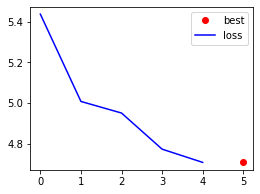

Best epoch so far:  5
Time  11.899 sec

Epoch 6 Batch 37 Loss: 4.7157
Epoch 6 Batch 74 Loss: 4.5368
Epoch 6 Batch 111 Loss: 4.5152
Epoch 6 Batch 148 Loss: 4.5039
Epoch 6 Batch 185 Loss: 4.5438
Epoch 6 Batch 222 Loss: 4.6411

*** Epoch 6 Loss 4.6008 ***

####################
Greedy| Q: Hello   A: i am i am i do not not not not not not not 
Beam  5 |  Hello   A: what 
%
Greedy| Q: How are you ?  A: i am 
Beam  5 |  How are you ?  A: you i 
%
Greedy| Q: What are you doing ?  A: i am i am 
Beam  5 |  What are you doing ?  A: what 
%
Greedy| Q: What is your favorite restaurant ?  A: i am do not not 
Beam  5 |  What is your favorite restaurant ?  A: no 
%
Greedy| Q: Do you want to go out ?  A: i am 
Beam  5 |  Do you want to go out ?  A: no 
####################
checkpoint saved!
Best epoch so far:  6
Time  11.123 sec

Epoch 7 Batch 37 Loss: 4.6618
Epoch 7 Batch 74 Loss: 4.5119
Epoch 7 Batch 111 Loss: 4.4514
Epoch 7 Batch 148 Loss: 4.4632
Epoch 7 Batch 185 Loss: 4.6813
Epoch 7 Batch 222 Loss

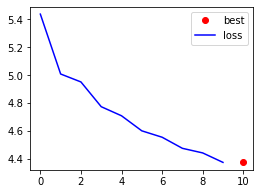

Best epoch so far:  10
Time  11.031 sec

Epoch 11 Batch 37 Loss: 4.4107
Epoch 11 Batch 74 Loss: 4.2824
Epoch 11 Batch 111 Loss: 4.2268
Epoch 11 Batch 148 Loss: 4.2544
Epoch 11 Batch 185 Loss: 4.4933
Epoch 11 Batch 222 Loss: 4.2332

*** Epoch 11 Loss 4.3493 ***

####################
Greedy| Q: Hello   A: i am sorry 
Beam  5 |  Hello   A: that 
%
Greedy| Q: How are you ?  A: i am not know 
Beam  5 |  How are you ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am not you 
Beam  5 |  What are you doing ?  A: i i 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
Beam  5 |  What is your favorite restaurant ?  A: that 
%
Greedy| Q: Do you want to go out ?  A: i am not 
Beam  5 |  Do you want to go out ?  A: i 
####################
checkpoint saved!
Best epoch so far:  11
Time  11.183 sec

Epoch 12 Batch 37 Loss: 4.3695
Epoch 12 Batch 74 Loss: 4.2683
Epoch 12 Batch 111 Loss: 4.2269
Epoch 12 Batch 148 Loss: 4.2831
Epoch 12 Batch 185 Loss: 4.2378
Epoch 12 Batch 222 Loss: 4.3717



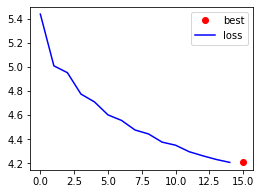

Best epoch so far:  15
Time  11.270 sec

Epoch 16 Batch 37 Loss: 4.2786
Epoch 16 Batch 74 Loss: 4.1437
Epoch 16 Batch 111 Loss: 4.1467
Epoch 16 Batch 148 Loss: 4.1371
Epoch 16 Batch 185 Loss: 4.0962
Epoch 16 Batch 222 Loss: 4.2471

*** Epoch 16 Loss 4.1825 ***

####################
Greedy| Q: Hello   A: i am not you 
Beam  5 |  Hello   A: yes 
%
Greedy| Q: How are you ?  A: i am not 
Beam  5 |  How are you ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am not 
Beam  5 |  What are you doing ?  A: i i 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
Beam  5 |  What is your favorite restaurant ?  A: that 
%
Greedy| Q: Do you want to go out ?  A: i am not 
Beam  5 |  Do you want to go out ?  A: i i 
####################
checkpoint saved!
Best epoch so far:  16
Time  11.142 sec

Epoch 17 Batch 37 Loss: 4.2733
Epoch 17 Batch 74 Loss: 4.1251
Epoch 17 Batch 111 Loss: 4.0870
Epoch 17 Batch 148 Loss: 4.0872
Epoch 17 Batch 185 Loss: 4.3196
Epoch 17 Batch 222 Loss: 4.1284

*** Ep

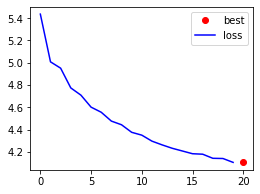

Best epoch so far:  20
Time  11.664 sec

Epoch 21 Batch 37 Loss: 4.1929
Epoch 21 Batch 74 Loss: 4.0074
Epoch 21 Batch 111 Loss: 4.0428
Epoch 21 Batch 148 Loss: 4.0763
Epoch 21 Batch 185 Loss: 4.2248
Epoch 21 Batch 222 Loss: 4.1181

*** Epoch 21 Loss 4.1049 ***

####################
Greedy| Q: Hello   A: i am not you 
Beam  5 |  Hello   A: yes 
%
Greedy| Q: How are you ?  A: i am not 
Beam  5 |  How are you ?  A: that 
%
Greedy| Q: What are you doing ?  A: i am not 
Beam  5 |  What are you doing ?  A: it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry 
Beam  5 |  What is your favorite restaurant ?  A: yes 
%
Greedy| Q: Do you want to go out ?  A: i am not 
Beam  5 |  Do you want to go out ?  A: that 
####################
Best epoch so far:  20
Time  11.444 sec

Epoch 22 Batch 37 Loss: 4.1786
Epoch 22 Batch 74 Loss: 4.0430
Epoch 22 Batch 111 Loss: 4.0364
Epoch 22 Batch 148 Loss: 4.0154
Epoch 22 Batch 185 Loss: 3.9573
Epoch 22 Batch 222 Loss: 4.0846

*** Epoch 22 Loss 4.07

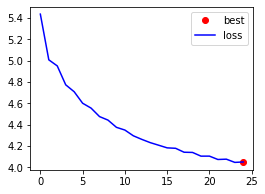

Best epoch so far:  24
Time  10.976 sec

Epoch 26 Batch 37 Loss: 4.1163
Epoch 26 Batch 74 Loss: 4.0068
Epoch 26 Batch 111 Loss: 3.9940
Epoch 26 Batch 148 Loss: 3.9643
Epoch 26 Batch 185 Loss: 3.9180
Epoch 26 Batch 222 Loss: 4.0266

*** Epoch 26 Loss 4.0199 ***

####################
Greedy| Q: Hello   A: i am not 
Beam  5 |  Hello   A: i is 
%
Greedy| Q: How are you ?  A: i am sorry 
Beam  5 |  How are you ?  A: no 
%
Greedy| Q: What are you doing ?  A: i do not know 
Beam  5 |  What are you doing ?  A: i you 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
Beam  5 |  What is your favorite restaurant ?  A: yes 
%
Greedy| Q: Do you want to go out ?  A: i am not 
Beam  5 |  Do you want to go out ?  A: i i 
####################
checkpoint saved!
Best epoch so far:  26
Time  10.725 sec

Epoch 27 Batch 37 Loss: 4.1703
Epoch 27 Batch 74 Loss: 3.9446
Epoch 27 Batch 111 Loss: 3.9484
Epoch 27 Batch 148 Loss: 4.0081
Epoch 27 Batch 185 Loss: 4.1287
Epoch 27 Batch 222 Loss: 4.0854

**

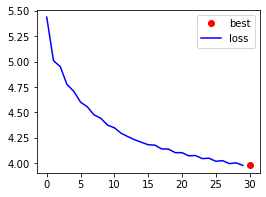

Best epoch so far:  30
Time  10.953 sec

Epoch 31 Batch 37 Loss: 4.1145
Epoch 31 Batch 74 Loss: 3.9084
Epoch 31 Batch 111 Loss: 3.9082
Epoch 31 Batch 148 Loss: 3.9512
Epoch 31 Batch 185 Loss: 4.0670
Epoch 31 Batch 222 Loss: 4.0573

*** Epoch 31 Loss 3.9868 ***

####################
Greedy| Q: Hello   A: i am not 
Beam  5 |  Hello   A: it 
%
Greedy| Q: How are you ?  A: i am not 
Beam  5 |  How are you ?  A: i i 
%
Greedy| Q: What are you doing ?  A: i am sorry 
Beam  5 |  What are you doing ?  A: what 
%
Greedy| Q: What is your favorite restaurant ?  A: i 
Beam  5 |  What is your favorite restaurant ?  A: yes 
%
Greedy| Q: Do you want to go out ?  A: i am not 
Beam  5 |  Do you want to go out ?  A: that 
####################
Best epoch so far:  30
Time  11.994 sec

Epoch 32 Batch 37 Loss: 4.0871
Epoch 32 Batch 74 Loss: 4.0422
Epoch 32 Batch 111 Loss: 3.8596
Epoch 32 Batch 148 Loss: 3.8162
Epoch 32 Batch 185 Loss: 3.9070
Epoch 32 Batch 222 Loss: 3.9522

*** Epoch 32 Loss 3.9592 ***

###

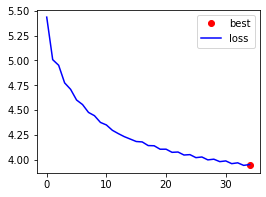

Best epoch so far:  34
Time  11.307 sec

Epoch 36 Batch 37 Loss: 4.0638
Epoch 36 Batch 74 Loss: 4.0187
Epoch 36 Batch 111 Loss: 3.8773
Epoch 36 Batch 148 Loss: 3.7283
Epoch 36 Batch 185 Loss: 3.8710
Epoch 36 Batch 222 Loss: 3.9318

*** Epoch 36 Loss 3.9252 ***

####################
Greedy| Q: Hello   A: i am not 
Beam  5 |  Hello   A: yeah 
%
Greedy| Q: How are you ?  A: i am not 
Beam  5 |  How are you ?  A: what 
%
Greedy| Q: What are you doing ?  A: i am not you 
Beam  5 |  What are you doing ?  A: what 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
Beam  5 |  What is your favorite restaurant ?  A: that 
%
Greedy| Q: Do you want to go out ?  A: i am not 
Beam  5 |  Do you want to go out ?  A: no 
####################
checkpoint saved!
Best epoch so far:  36
Time  11.319 sec

Epoch 37 Batch 37 Loss: 4.0691
Epoch 37 Batch 74 Loss: 3.8592
Epoch 37 Batch 111 Loss: 3.8271
Epoch 37 Batch 148 Loss: 3.8075
Epoch 37 Batch 185 Loss: 3.9472
Epoch 37 Batch 222 Loss: 4.0171

*** 

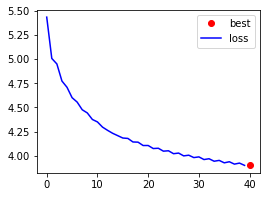

Best epoch so far:  40
Time  12.805 sec

Epoch 41 Batch 37 Loss: 4.0053
Epoch 41 Batch 74 Loss: 3.8105
Epoch 41 Batch 111 Loss: 3.8040
Epoch 41 Batch 148 Loss: 3.7940
Epoch 41 Batch 185 Loss: 3.9421
Epoch 41 Batch 222 Loss: 3.9810

*** Epoch 41 Loss 3.9073 ***

####################
Greedy| Q: Hello   A: i am a good 
Beam  5 |  Hello   A: that 
%
Greedy| Q: How are you ?  A: i am not 
Beam  5 |  How are you ?  A: no 
%
Greedy| Q: What are you doing ?  A: i am not 
Beam  5 |  What are you doing ?  A: it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not you 
Beam  5 |  What is your favorite restaurant ?  A: that 
%
Greedy| Q: Do you want to go out ?  A: i am not you 
Beam  5 |  Do you want to go out ?  A: that 
####################
Best epoch so far:  40
Time  12.677 sec

Epoch 42 Batch 37 Loss: 4.0495
Epoch 42 Batch 74 Loss: 4.0634
Epoch 42 Batch 111 Loss: 3.8542
Epoch 42 Batch 148 Loss: 3.6860
Epoch 42 Batch 185 Loss: 3.8410
Epoch 42 Batch 222 Loss: 3.8725

*** Epoch 42 Loss

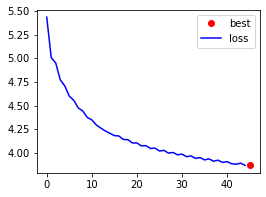

Best epoch so far:  45
Time  11.311 sec

Epoch 46 Batch 37 Loss: 3.9796
Epoch 46 Batch 74 Loss: 3.8800
Epoch 46 Batch 111 Loss: 3.7721
Epoch 46 Batch 148 Loss: 3.7988
Epoch 46 Batch 185 Loss: 4.0826
Epoch 46 Batch 222 Loss: 3.7935

*** Epoch 46 Loss 3.8782 ***

####################
Greedy| Q: Hello   A: i am not 
Beam  5 |  Hello   A: it 
%
Greedy| Q: How are you ?  A: i am not 
Beam  5 |  How are you ?  A: it 
%
Greedy| Q: What are you doing ?  A: i am not 
Beam  5 |  What are you doing ?  A: it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
Beam  5 |  What is your favorite restaurant ?  A: yes 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
Beam  5 |  Do you want to go out ?  A: it 
####################
Best epoch so far:  45
Time  12.222 sec

Epoch 47 Batch 37 Loss: 3.9927
Epoch 47 Batch 74 Loss: 3.8231
Epoch 47 Batch 111 Loss: 3.7610
Epoch 47 Batch 148 Loss: 3.7072
Epoch 47 Batch 185 Loss: 3.8674
Epoch 47 Batch 222 Loss: 3.9935

*** Epoch 47 Loss 3.8560 ***

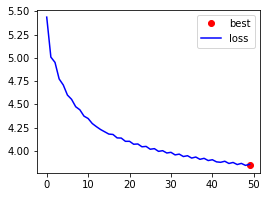

Best epoch so far:  49
Time  11.465 sec

Epoch 51 Batch 37 Loss: 3.9392
Epoch 51 Batch 74 Loss: 3.7920
Epoch 51 Batch 111 Loss: 3.7804
Epoch 51 Batch 148 Loss: 3.7846
Epoch 51 Batch 185 Loss: 3.8039
Epoch 51 Batch 222 Loss: 3.9757

*** Epoch 51 Loss 3.8367 ***

####################
Greedy| Q: Hello   A: i am not 
Beam  5 |  Hello   A: hi 
%
Greedy| Q: How are you ?  A: i am not 
Beam  5 |  How are you ?  A: it 
%
Greedy| Q: What are you doing ?  A: i am not 
Beam  5 |  What are you doing ?  A: i is 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
Beam  5 |  What is your favorite restaurant ?  A: that 
%
Greedy| Q: Do you want to go out ?  A: i am not you 
Beam  5 |  Do you want to go out ?  A: that 
####################
checkpoint saved!
Best epoch so far:  51
Time  11.024 sec

Epoch 52 Batch 37 Loss: 3.9265
Epoch 52 Batch 74 Loss: 3.7904
Epoch 52 Batch 111 Loss: 3.7578
Epoch 52 Batch 148 Loss: 3.7330
Epoch 52 Batch 185 Loss: 4.0321
Epoch 52 Batch 222 Loss: 3.8243

*** Ep

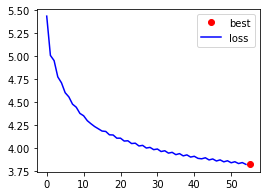

Best epoch so far:  55
Time  11.306 sec

Epoch 56 Batch 37 Loss: 3.9069
Epoch 56 Batch 74 Loss: 4.0874
Epoch 56 Batch 111 Loss: 3.8500
Epoch 56 Batch 148 Loss: 3.6828
Epoch 56 Batch 185 Loss: 3.8006
Epoch 56 Batch 222 Loss: 3.8377

*** Epoch 56 Loss 3.8166 ***

####################
Greedy| Q: Hello   A: i am not 
Beam  5 |  Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
Beam  5 |  How are you ?  A: i is 
%
Greedy| Q: What are you doing ?  A: i am not 
Beam  5 |  What are you doing ?  A: no 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
Beam  5 |  What is your favorite restaurant ?  A: i 
%
Greedy| Q: Do you want to go out ?  A: i am sure 
Beam  5 |  Do you want to go out ?  A: i 
####################
checkpoint saved!
Best epoch so far:  56
Time  11.864 sec

Epoch 57 Batch 37 Loss: 3.8982
Epoch 57 Batch 74 Loss: 3.7742
Epoch 57 Batch 111 Loss: 3.7634
Epoch 57 Batch 148 Loss: 3.7473
Epoch 57 Batch 185 Loss: 3.7691
Epoch 57 Batch 222 Loss: 3.9115

*** Epoch 57

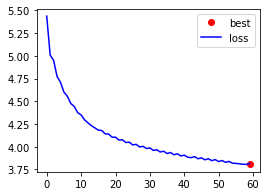

Best epoch so far:  59
Time  11.975 sec

Epoch 61 Batch 37 Loss: 3.9063
Epoch 61 Batch 74 Loss: 3.7714
Epoch 61 Batch 111 Loss: 3.7613
Epoch 61 Batch 148 Loss: 3.7060
Epoch 61 Batch 185 Loss: 3.7084
Epoch 61 Batch 222 Loss: 3.8915

*** Epoch 61 Loss 3.7970 ***

####################
Greedy| Q: Hello   A: hi 
Beam  5 |  Hello   A: what 
%
Greedy| Q: How are you ?  A: i am not 
Beam  5 |  How are you ?  A: no 
%
Greedy| Q: What are you doing ?  A: i am not 
Beam  5 |  What are you doing ?  A: we 
%
Greedy| Q: What is your favorite restaurant ?  A: i am going to do 
Beam  5 |  What is your favorite restaurant ?  A: no 
%
Greedy| Q: Do you want to go out ?  A: i am not 
Beam  5 |  Do you want to go out ?  A: it 
####################
checkpoint saved!
Best epoch so far:  61
Time  11.383 sec

Epoch 62 Batch 37 Loss: 3.9026
Epoch 62 Batch 74 Loss: 3.7211
Epoch 62 Batch 111 Loss: 3.7389
Epoch 62 Batch 148 Loss: 3.7207
Epoch 62 Batch 185 Loss: 3.9336
Epoch 62 Batch 222 Loss: 3.8745

*** Epoch 62

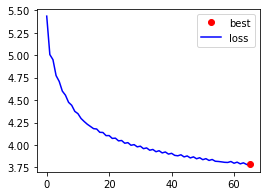

Best epoch so far:  65
Time  11.729 sec

Epoch 66 Batch 37 Loss: 3.9226
Epoch 66 Batch 74 Loss: 3.7501
Epoch 66 Batch 111 Loss: 3.7504
Epoch 66 Batch 148 Loss: 3.7563
Epoch 66 Batch 185 Loss: 3.9309
Epoch 66 Batch 222 Loss: 3.8588

*** Epoch 66 Loss 3.7949 ***

####################
Greedy| Q: Hello   A: i am not 
Beam  5 |  Hello   A: yes 
%
Greedy| Q: How are you ?  A: i am not 
Beam  5 |  How are you ?  A: it 
%
Greedy| Q: What are you doing ?  A: i am not you 
Beam  5 |  What are you doing ?  A: because 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
Beam  5 |  What is your favorite restaurant ?  A: he 
%
Greedy| Q: Do you want to go out ?  A: i am not going to be 
Beam  5 |  Do you want to go out ?  A: what 
####################
Best epoch so far:  65
Time  11.125 sec

Epoch 67 Batch 37 Loss: 3.8600
Epoch 67 Batch 74 Loss: 3.7645
Epoch 67 Batch 111 Loss: 3.7238
Epoch 67 Batch 148 Loss: 3.6921
Epoch 67 Batch 185 Loss: 3.6892
Epoch 67 Batch 222 Loss: 3.8355

*** Epoch 

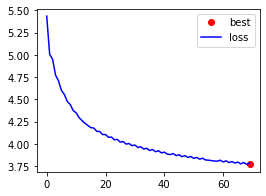

Best epoch so far:  69
Time  11.405 sec

Epoch 71 Batch 37 Loss: 3.8928
Epoch 71 Batch 74 Loss: 3.7719
Epoch 71 Batch 111 Loss: 3.6798
Epoch 71 Batch 148 Loss: 3.6547
Epoch 71 Batch 185 Loss: 3.6789
Epoch 71 Batch 222 Loss: 3.8008

*** Epoch 71 Loss 3.7654 ***

####################
Greedy| Q: Hello   A: i am not 
Beam  5 |  Hello   A: yeah 
%
Greedy| Q: How are you ?  A: i do not know 
Beam  5 |  How are you ?  A: i i 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
Beam  5 |  What are you doing ?  A: what 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
Beam  5 |  What is your favorite restaurant ?  A: he 
%
Greedy| Q: Do you want to go out ?  A: i am not 
Beam  5 |  Do you want to go out ?  A: what 
####################
checkpoint saved!
Best epoch so far:  71
Time  11.565 sec

Epoch 72 Batch 37 Loss: 3.9160
Epoch 72 Batch 74 Loss: 3.6817
Epoch 72 Batch 111 Loss: 3.7165
Epoch 72 Batch 148 Loss: 3.7320
Epoch 72 Batch 185 Loss: 3.8598
Epoch 72 Batc

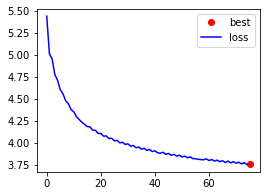

Best epoch so far:  75
Time  11.012 sec

Epoch 76 Batch 37 Loss: 3.8922
Epoch 76 Batch 74 Loss: 3.6876
Epoch 76 Batch 111 Loss: 3.6898
Epoch 76 Batch 148 Loss: 3.6915
Epoch 76 Batch 185 Loss: 3.8423
Epoch 76 Batch 222 Loss: 3.8771

*** Epoch 76 Loss 3.7666 ***

####################
Greedy| Q: Hello   A: i am not 
Beam  5 |  Hello   A: yes 
%
Greedy| Q: How are you ?  A: i am not 
Beam  5 |  How are you ?  A: do 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
Beam  5 |  What are you doing ?  A: because 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
Beam  5 |  What is your favorite restaurant ?  A: that 
%
Greedy| Q: Do you want to go out ?  A: i am not 
Beam  5 |  Do you want to go out ?  A: yes 
####################
Best epoch so far:  75
Time  10.778 sec

Epoch 77 Batch 37 Loss: 3.8811
Epoch 77 Batch 74 Loss: 3.8101
Epoch 77 Batch 111 Loss: 3.6627
Epoch 77 Batch 148 Loss: 3.5701
Epoch 77 Batch 185 Loss: 3.6821
Epoch 77 Batch 222 Loss: 3.7785

*** Epoch 77 

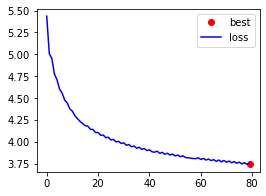

Best epoch so far:  79
Time  11.288 sec

Epoch 81 Batch 37 Loss: 3.8753
Epoch 81 Batch 74 Loss: 3.8579
Epoch 81 Batch 111 Loss: 3.6790
Epoch 81 Batch 148 Loss: 3.5404
Epoch 81 Batch 185 Loss: 3.6849
Epoch 81 Batch 222 Loss: 3.7316

*** Epoch 81 Loss 3.7356 ***

####################
Greedy| Q: Hello   A: i am not 
Beam  5 |  Hello   A: yes 
%
Greedy| Q: How are you ?  A: i am not 
Beam  5 |  How are you ?  A: it 
%
Greedy| Q: What are you doing ?  A: i am not you 
Beam  5 |  What are you doing ?  A: what 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
Beam  5 |  What is your favorite restaurant ?  A: that 
%
Greedy| Q: Do you want to go out ?  A: i am not 
Beam  5 |  Do you want to go out ?  A: what 
####################
checkpoint saved!
Best epoch so far:  81
Time  11.965 sec

Epoch 82 Batch 37 Loss: 3.8897
Epoch 82 Batch 74 Loss: 3.6522
Epoch 82 Batch 111 Loss: 3.6630
Epoch 82 Batch 148 Loss: 3.6470
Epoch 82 Batch 185 Loss: 3.7850
Epoch 82 Batch 222 Loss: 3.8737

*** E

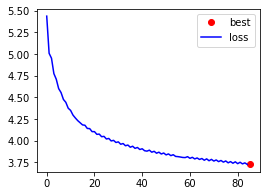

Best epoch so far:  85
Time  12.637 sec

Epoch 86 Batch 37 Loss: 3.9025
Epoch 86 Batch 74 Loss: 3.6636
Epoch 86 Batch 111 Loss: 3.6613
Epoch 86 Batch 148 Loss: 3.5421
Epoch 86 Batch 185 Loss: 3.7892
Epoch 86 Batch 222 Loss: 3.8796

*** Epoch 86 Loss 3.7261 ***

####################
Greedy| Q: Hello   A: hi 
Beam  5 |  Hello   A: what 
%
Greedy| Q: How are you ?  A: i am sorry 
Beam  5 |  How are you ?  A: nothing 
%
Greedy| Q: What are you doing ?  A: i am sorry 
Beam  5 |  What are you doing ?  A: because 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
Beam  5 |  What is your favorite restaurant ?  A: it 
%
Greedy| Q: Do you want to go out ?  A: i am not 
Beam  5 |  Do you want to go out ?  A: i i 
####################
checkpoint saved!
Best epoch so far:  86
Time  12.160 sec

Epoch 87 Batch 37 Loss: 3.8416
Epoch 87 Batch 74 Loss: 3.7650
Epoch 87 Batch 111 Loss: 3.6306
Epoch 87 Batch 148 Loss: 3.6434
Epoch 87 Batch 185 Loss: 3.9750
Epoch 87 Batch 222 Loss: 3.7120

*** E

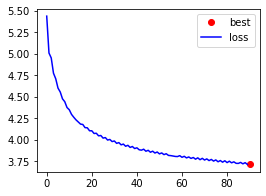

Best epoch so far:  90
Time  11.529 sec

Epoch 91 Batch 37 Loss: 3.8285
Epoch 91 Batch 74 Loss: 3.6778
Epoch 91 Batch 111 Loss: 3.6302
Epoch 91 Batch 148 Loss: 3.6514
Epoch 91 Batch 185 Loss: 3.9067
Epoch 91 Batch 222 Loss: 3.7233

*** Epoch 91 Loss 3.7281 ***

####################
Greedy| Q: Hello   A: i am not going to do 
Beam  5 |  Hello   A: what 
%
Greedy| Q: How are you ?  A: i am not 
Beam  5 |  How are you ?  A: what 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
Beam  5 |  What are you doing ?  A: i 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
Beam  5 |  What is your favorite restaurant ?  A: i i 
%
Greedy| Q: Do you want to go out ?  A: i am not 
Beam  5 |  Do you want to go out ?  A: i 
####################
Best epoch so far:  90
Time  12.228 sec

Epoch 92 Batch 37 Loss: 3.8237
Epoch 92 Batch 74 Loss: 3.6877
Epoch 92 Batch 111 Loss: 3.6193
Epoch 92 Batch 148 Loss: 3.5365
Epoch 92 Batch 185 Loss: 3.7323
Epoch 92 Batch 222 Loss: 3.8553

*** Epo

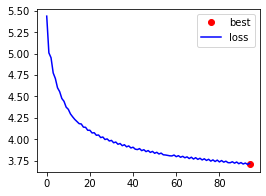

Best epoch so far:  94
Time  11.476 sec

Epoch 96 Batch 37 Loss: 3.7821
Epoch 96 Batch 74 Loss: 3.6892
Epoch 96 Batch 111 Loss: 3.6415
Epoch 96 Batch 148 Loss: 3.6125
Epoch 96 Batch 185 Loss: 3.6611
Epoch 96 Batch 222 Loss: 3.8504

*** Epoch 96 Loss 3.7021 ***

####################
Greedy| Q: Hello   A: hi 
Beam  5 |  Hello   A: yes 
%
Greedy| Q: How are you ?  A: i am not 
Beam  5 |  How are you ?  A: no 
%
Greedy| Q: What are you doing ?  A: i am not 
Beam  5 |  What are you doing ?  A: nothing 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
Beam  5 |  What is your favorite restaurant ?  A: he 
%
Greedy| Q: Do you want to go out ?  A: i am not 
Beam  5 |  Do you want to go out ?  A: i 
####################
checkpoint saved!
Best epoch so far:  96
Time  11.082 sec

Epoch 97 Batch 37 Loss: 3.8077
Epoch 97 Batch 74 Loss: 3.6259
Epoch 97 Batch 111 Loss: 3.6663
Epoch 97 Batch 148 Loss: 3.6100
Epoch 97 Batch 185 Loss: 3.8832
Epoch 97 Batch 222 Loss: 3.7060

*** Epoch 97 Loss

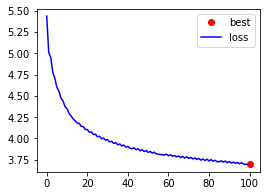

Best epoch so far:  100
Time  10.794 sec



In [26]:
import math
X, y = [], []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def plot_history():
    plt.figure(figsize=(4,3))
    plt.plot(best_ep,smallest_loss,'ro')
    plt.plot(history['loss'],'b-')
    plt.legend(['best','loss'])
    plt.show()

for ep in range(current_ep,EPOCHS+1):
    current_ep = ep
    start = time.time()
    total_loss = 0
    btch = 1

    for p in pairs_final_train:

        question = p[0]
        label = p[1]
        # find the index of each word of the caption in vocabulary
        question_seq = [wordtoix[word] for word in question.split(' ') if word in wordtoix]
        label_seq = [wordtoix[word] for word in label.split(' ') if word in wordtoix]
        # encoder input and decoder input and label
        enc_in_seq = pad_sequences([question_seq], maxlen=max_len_q)[0]
        dec_out_seq = pad_sequences([label_seq], maxlen=max_len_a)[0]

        X.append(enc_in_seq)
        y.append(dec_out_seq)

        if len(X) == batch_size :

            batch_loss = train_step(
                torch.Tensor(X).to(torch.int32),
                torch.Tensor(y).to(torch.long),
                enc_hidden,
                device
                )
            if not math.isnan(batch_loss):
              total_loss += batch_loss
              btch += 1
            X , y = [], []
            if btch % (steps_per_epoch//6) == 0:
                print('Epoch {} Batch {} Loss: {:.4f}'.format(ep , btch, batch_loss))
    epoch_loss =  total_loss / steps_per_epoch
    print('\n*** Epoch {} Loss {:.4f} ***\n'.format(ep ,epoch_loss))
    history['loss'].append(epoch_loss)


    test_bot(beam=True)

    if epoch_loss < smallest_loss:
        smallest_loss = epoch_loss
        best_ep = ep

        torch.save(encoder, f'encoder_{ep}.pth')
        torch.save(decoder, f'decoder_{ep}.pth')

        print('checkpoint saved!')

    if ep % 5 == 0:
        plot_history()

    print('Best epoch so far: ',best_ep)
    print('Time  {:.3f} sec\n'.format(time.time() - start))

    print('=' * 40)

Now we can load our best model and chat with our system. We also plot the attention weights.

In [27]:

encoder = torch.load(f'encoder_{best_ep}.pth', weights_only=False)
decoder = torch.load(f'decoder_{best_ep}.pth', weights_only=False)

print('load best checkpoint from ep:', best_ep)
test_bot(k=5,beam=True)


load best checkpoint from ep: 100
####################
Greedy| Q: Hello   A: i am sorry 


Beam  5 |  Hello   A: what 
%
Greedy| Q: How are you ?  A: i am not going to do 
Beam  5 |  How are you ?  A: i 
%
Greedy| Q: What are you doing ?  A: i am not 
Beam  5 |  What are you doing ?  A: nothing 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
Beam  5 |  What is your favorite restaurant ?  A: what 
%
Greedy| Q: Do you want to go out ?  A: i am not 
Beam  5 |  Do you want to go out ?  A: yes 
####################


Input: how old are you
Predicted answer: i am not 


/tmp/ipykernel_3833/4229615246.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_3833/4229615246.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


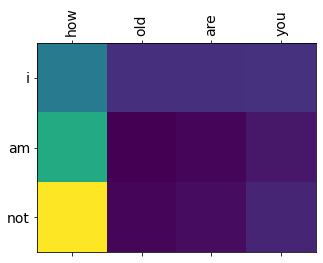

In [28]:
q = "How old are you"
answer(q, training=False)


Input: do you drink
Predicted answer: i am 


/tmp/ipykernel_3833/4229615246.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_3833/4229615246.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


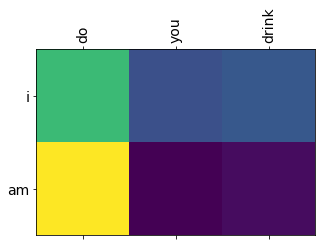

In [29]:
q = "Do you drink"
answer(q, training=False)


**Task 3** Let's look at the attention weights and compare them after 5, 50 and 100 epochs. Instead of evaluating by an automatic evaluation method, you can show us 10 predictions for each model. Answer the following questions based on your predictions, giving examples and/or explaining the evidence for your answers.


*   Did the models learn to track local relations between words?

*   Did the models attend to the least frequent tokens in an utterance? Can you see signs of overfitting in models that hang on to the least frequent words?

*   Did the models learn to track some major syntactic relations in the utterances (e.g. subject-verb, verb-object)?

*   Do they learn to encode some other linguistic features? Do they capture part-of-speech tags (POS tags)?

*   What is the effect of more training on the length of responss?

*   In some instances, by the time the decoder has to generate the beginning of a response, it may already forget the most relevant early query tokens. Can you suggest ways to change the training pipeline to make it easier for the model to remember the beginning of the query when it starts to generate the response?

In [46]:
def train_and_save_checkpoints(pairs_final_train, encoder, decoder, epochs=100, batch_size=512):
    import math, time
    X, y = [], []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    enc_hidden = encoder.initialize_hidden_state().to(device)
    encoder.to(device)
    decoder.to(device)

    optimizer_enc = torch.optim.Adam(encoder.parameters(), lr=init_lr)
    optimizer_dec = torch.optim.Adam(decoder.parameters(), lr=init_lr)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)

    for ep in range(1, epochs + 1):
        start = time.time()
        total_loss = 0
        btch = 1

        for p in pairs_final_train:
            question, label = p
            question_seq = [wordtoix.get(word, wordtoix['i']) for word in question.split()]
            label_seq = [wordtoix.get(word, wordtoix['i']) for word in label.split()]
            enc_in_seq = pad_sequences([question_seq], maxlen=max_len_q)[0]
            dec_out_seq = pad_sequences([label_seq], maxlen=max_len_a)[0]

            X.append(enc_in_seq)
            y.append(dec_out_seq)

            if len(X) == batch_size:
                inp = torch.Tensor(X).to(torch.int32).to(device)
                targ = torch.Tensor(y).to(torch.long).to(device)

                encoder.train()
                decoder.train()
                optimizer_enc.zero_grad()
                optimizer_dec.zero_grad()
                loss = 0.0
                enc_output, enc_hidden_f, enc_hidden_b = encoder(inp, enc_hidden)
                dec_hidden = torch.cat([enc_hidden_f, enc_hidden_b], dim=-1)
                dec_input = torch.tensor([wordtoix[start_token]] * batch_size, dtype=torch.long, device=device).unsqueeze(1)

                for t in range(1, targ.size(1)):
                    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                    dec_hidden = dec_hidden[0]
                    step_loss = loss_fn(predictions, targ[:, t])
                    loss += step_loss
                    dec_input = targ[:, t].unsqueeze(1)

                loss.backward()
                torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5.0)
                torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5.0)
                optimizer_enc.step()
                optimizer_dec.step()

                total_loss += loss.item() / targ.size(1)
                X, y = [], []
                btch += 1

        epoch_loss = total_loss / btch
        print(f"\n*** Epoch {ep} Loss {epoch_loss:.4f} ***\n")

        if ep in [5, 50, 100]:
            torch.save(encoder.state_dict(), f'encoder_epoch{ep}_weights.pth')
            torch.save(decoder.state_dict(), f'decoder_epoch{ep}_weights.pth')
            print(f"Saved checkpoint at epoch {ep}")


In [47]:
# adding a print weight to the evaluate function to compare attention weights in different epochs
def evaluate(sentence, device):
    encoder.to(device)
    decoder.to(device)

    attention_plot = np.zeros((max_len_a, max_len_q))

    sentence = unicode_to_ascii(sentence.lower())

    # Use 'i' as a safe fallback for unknown words
    inputs = [wordtoix[i] if i in wordtoix else wordtoix['i'] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]] + inputs + [wordtoix[end_token]]
    inputs = pad_sequences([inputs], maxlen=max_len_q)

    inputs = torch.Tensor(inputs).to(torch.int32).to(device)

    result = ''
    hidden = torch.zeros(2, inputs.shape[0], GRU_units).to(device)
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = torch.cat((enc_hidden_f, enc_hidden_b), dim=-1)
    dec_input = torch.tensor([[wordtoix[start_token]]], device=device)

    all_attention_weights = []

    for t in range(max_len_a):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        dec_hidden = dec_hidden[0]

        attention_weights_np = attention_weights.squeeze(0).view(-1).detach().cpu().numpy()
        all_attention_weights.append(attention_weights_np)

        predicted_id = predictions.argmax(dim=1).item()

        if ixtoword[predicted_id] == end_token:
            break

        result += ixtoword[predicted_id] + ' '
        dec_input = torch.tensor([[predicted_id]], device=device)

    attention_array = np.array(all_attention_weights)
    return result.strip(), sentence, attention_array

In [50]:
def evaluate_epochs(questions, encoder_class, decoder_class):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    epochs = [5, 50, 100]

    for ep in epochs:
        print(f"\n========== EPOCH {ep} ==========\n")

        encoder = encoder_class(vocab_size=vocab_len, embedding_dim=emb_dim, enc_units=GRU_units).to(device)
        decoder = decoder_class(vocab_size=vocab_len, embedding_dim=emb_dim, dec_units=GRU_units).to(device)

        encoder.load_state_dict(torch.load(f'encoder_epoch{ep}_weights.pth'))
        decoder.load_state_dict(torch.load(f'decoder_epoch{ep}_weights.pth'))

        encoder.eval()
        decoder.eval()

        for i, q in enumerate(questions):
            result, input_sentence, attn_weights = evaluate(q, device)

            print(f"Q{i+1}: {input_sentence}")
            print(f"A{i+1} (Epoch {ep}): {result}")
            print("Attention weights (first 3 timesteps):")
            print(attn_weights[:3])

            input_tokens = input_sentence.split()
            output_tokens = result.split()
            trimmed_attention = attn_weights[:len(output_tokens), :len(input_tokens)]

            plot_attention(trimmed_attention, input_tokens, output_tokens)


In [ ]:
encoder = torch.load(f'new_encoder_5.pth', weights_only=False)
decoder = torch.load(f'new_decoder_5.pth', weights_only=False)
evaluate("What are you doing", device)


('i am',
 'what are you doing',
 array([[0.0568709 , 0.05687876, 0.05525279, 0.05545735, 0.05643758,
         0.05666106, 0.05667836, 0.05668225, 0.05668139, 0.05667501,
         0.05665042, 0.05654921, 0.05618304, 0.05531918, 0.05412993,
         0.05303792, 0.05222043, 0.05163439],
        [0.06689814, 0.20348793, 0.15408726, 0.12249034, 0.08969233,
         0.05622826, 0.05138063, 0.04949486, 0.04806389, 0.04617952,
         0.0420367 , 0.03161854, 0.01676882, 0.00796298, 0.00469806,
         0.00345244, 0.00288575, 0.00257349],
        [0.2672836 , 0.14086847, 0.06310593, 0.04883299, 0.04657076,
         0.04540509, 0.04505567, 0.04486464, 0.0446064 , 0.04407484,
         0.04256397, 0.03838107, 0.03140518, 0.02502766, 0.02090589,
         0.0184236 , 0.01686314, 0.01576114]], dtype=float32))

In [36]:
questions = [
    "hi",
    "how are you",
    "what are you doing",
    "what is your favorite restaurant",
    "how is the weather",
    "do you want to go out",
    "can you help me?",
    "where is the book",
    "do you have a problem",
    "what is your name"
]


In [ ]:
# Train your model
train_and_save_checkpoints(pairs_final_train, encoder, decoder, epochs=100)

# Then evaluate your checkpoints
questions = [
    "hi", "how are you", "what are you doing",
    "what is your favorite restaurant", "how is the weather",
    "do you want to go out", "can you help me", "where is the book",
    "do you have a problem", "what is your name"
]





*** Epoch 1 Loss 3.7058 ***


*** Epoch 2 Loss 3.6860 ***


*** Epoch 3 Loss 3.6807 ***


*** Epoch 4 Loss 3.6783 ***


*** Epoch 5 Loss 3.6749 ***

Saved checkpoint at epoch 5

*** Epoch 6 Loss 3.6736 ***


*** Epoch 7 Loss 3.6701 ***


*** Epoch 8 Loss 3.6680 ***


*** Epoch 9 Loss 3.6646 ***


*** Epoch 10 Loss 3.6641 ***


*** Epoch 11 Loss 3.6621 ***


*** Epoch 12 Loss 3.6604 ***


*** Epoch 13 Loss nan ***


*** Epoch 14 Loss 3.6570 ***


*** Epoch 15 Loss nan ***


*** Epoch 16 Loss 3.6563 ***


*** Epoch 17 Loss 3.6536 ***


*** Epoch 18 Loss 3.6508 ***


*** Epoch 19 Loss 3.6491 ***


*** Epoch 20 Loss 3.6489 ***


*** Epoch 21 Loss 3.6449 ***


*** Epoch 22 Loss 3.6450 ***


*** Epoch 23 Loss 3.6420 ***


*** Epoch 24 Loss 3.6404 ***


*** Epoch 25 Loss 3.6401 ***


*** Epoch 26 Loss 3.6393 ***


*** Epoch 27 Loss 3.6359 ***


*** Epoch 28 Loss 3.6339 ***


*** Epoch 29 Loss 3.6308 ***


*** Epoch 30 Loss 3.6321 ***


*** Epoch 31 Loss 3.6321 ***


*** Epoch 32 Loss 3.6296 

NameError: name 'evaluate_epochs' is not defined


========== EPOCH 5 ==========

Loading glove...
GloVe 50 loaded!
Q1: hi
A1 (Epoch 5): hi
Attention weights (first 3 timesteps):
[[0.02282783 0.0424401  0.10814705 0.12398694 0.11246736 0.05402999
  0.05635047 0.05493404 0.05390513 0.05611762 0.05646053 0.05304451
  0.04749694 0.04013231 0.03228827 0.02755926 0.02739925 0.03041243]
 [0.28093454 0.12610242 0.12631932 0.12242191 0.08978078 0.03131248
  0.0278805  0.02570717 0.02318767 0.02161353 0.02001088 0.0183375
  0.01676097 0.0152935  0.01394354 0.01304161 0.01321277 0.01413888]]


/tmp/ipykernel_3833/3776040680.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_3833/3776040680.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


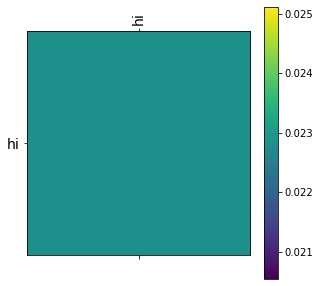

Q2: how are you
A2 (Epoch 5): i am not
Attention weights (first 3 timesteps):
[[0.02341124 0.03585913 0.11423407 0.0926618  0.08731876 0.05997868
  0.06930523 0.06778803 0.06200536 0.05868837 0.05599571 0.05188218
  0.0464172  0.04018729 0.03466093 0.0318211  0.03256167 0.03522328]
 [0.28990352 0.12353267 0.12929036 0.10954015 0.09244919 0.02788772
  0.02375809 0.02285722 0.02185478 0.02105903 0.02032447 0.01965854
  0.018905   0.01761444 0.01594653 0.01490821 0.01487745 0.01563261]
 [0.36443415 0.04948749 0.05487031 0.08723927 0.08798657 0.06019593
  0.03109147 0.02920395 0.02761237 0.02672054 0.02547903 0.02439587
  0.02362965 0.02278265 0.02157253 0.02063945 0.02084963 0.02180913]]


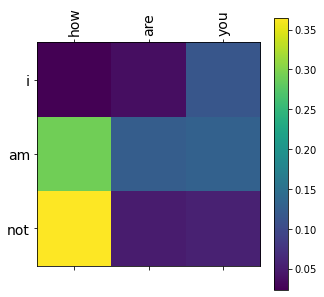

Q3: what are you doing
A3 (Epoch 5): i am not
Attention weights (first 3 timesteps):
[[0.02394715 0.05294283 0.11665304 0.08998376 0.08764516 0.04881389
  0.06426619 0.06764817 0.06367794 0.06052561 0.05722804 0.05232763
  0.04609485 0.03931084 0.03348553 0.03047404 0.03116709 0.03380821]
 [0.29656684 0.12032633 0.1226069  0.10903386 0.09953014 0.02989326
  0.02438184 0.02286961 0.02160305 0.02062707 0.01967761 0.01887492
  0.01805006 0.01676016 0.01532166 0.01447961 0.0144054  0.01499171]
 [0.34019077 0.05593636 0.05594681 0.08248743 0.08050933 0.05523998
  0.03555327 0.03263062 0.03049402 0.03005248 0.02983522 0.02923808
  0.02781309 0.02551956 0.02287904 0.02119653 0.02147738 0.02299997]]


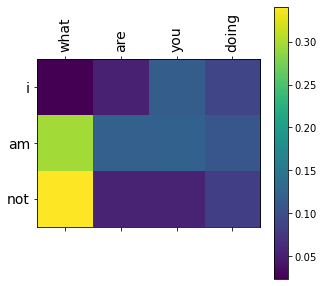

Q4: what is your favorite restaurant
A4 (Epoch 5): i am not going to be
Attention weights (first 3 timesteps):
[[0.02843062 0.03982775 0.12160762 0.09313315 0.0986081  0.03647313
  0.06913337 0.0702305  0.06489971 0.0601952  0.05533534 0.05110084
  0.04626228 0.04024323 0.03398133 0.02969014 0.02921624 0.03163153]
 [0.30079526 0.11748348 0.12216815 0.11531448 0.09724335 0.02617204
  0.02503406 0.02347242 0.02237294 0.02111951 0.01989602 0.01878451
  0.01751396 0.01589108 0.01455125 0.01386949 0.01390429 0.01441374]
 [0.35670236 0.04623841 0.0552857  0.09183566 0.08734401 0.04828694
  0.04142572 0.03734174 0.03309613 0.02923795 0.0268058  0.02522671
  0.02371304 0.02170824 0.01924888 0.0179238  0.01850719 0.02007171]]


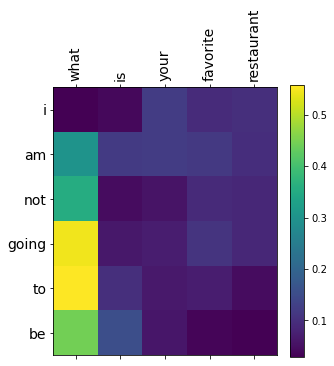

Q5: how is the weather
A5 (Epoch 5): i am not going to be a long time
Attention weights (first 3 timesteps):
[[0.02949463 0.0947777  0.09126252 0.07585797 0.07271254 0.06713584
  0.07078093 0.06954589 0.06453238 0.06116182 0.05774879 0.05183385
  0.04447975 0.03663958 0.03011131 0.02653612 0.0265306  0.0288577 ]
 [0.28828174 0.12941612 0.12617034 0.12092604 0.08210655 0.02712404
  0.02438257 0.02328408 0.02201345 0.02105275 0.02028016 0.01961105
  0.01876578 0.01722886 0.01539905 0.01440379 0.01442419 0.01512949]
 [0.33885872 0.04593991 0.0583465  0.08935707 0.09071457 0.06835607
  0.04115711 0.03538591 0.03020034 0.02750574 0.02556927 0.0243095
  0.02329503 0.02194593 0.02012797 0.01888098 0.01932759 0.02072168]]


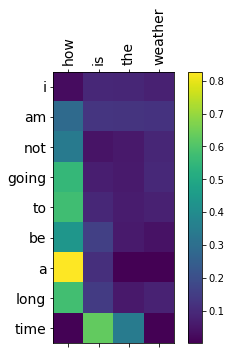

Q6: do you want to go out
A6 (Epoch 5): i am not going to do
Attention weights (first 3 timesteps):
[[0.01994524 0.06103015 0.10569087 0.10389205 0.09710234 0.04085735
  0.04942231 0.0345334  0.03688901 0.04893399 0.05762633 0.05812751
  0.05542409 0.05091242 0.04582182 0.04286619 0.04389863 0.04702625]
 [0.32033834 0.1152487  0.11542689 0.11121306 0.08663463 0.02833501
  0.02334383 0.02143421 0.0207105  0.02010372 0.0194888  0.01899694
  0.01844614 0.01746139 0.01605823 0.0151603  0.0153338  0.01626547]
 [0.34226876 0.04579518 0.05762438 0.08735335 0.0869587  0.07621972
  0.03737687 0.03534285 0.03111616 0.02918925 0.02725859 0.02510537
  0.02314413 0.0210229  0.01875227 0.01760138 0.01816569 0.01970445]]


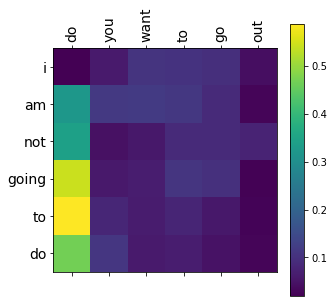

Q7: can you help me
A7 (Epoch 5): i am sorry
Attention weights (first 3 timesteps):
[[0.02019569 0.05713512 0.10358944 0.10008742 0.08801941 0.03800753
  0.04074712 0.0380705  0.04130331 0.05296475 0.06030632 0.05996555
  0.05714765 0.0529694  0.0482313  0.04543537 0.04645504 0.04936904]
 [0.270424   0.11844026 0.12688257 0.12667751 0.09738542 0.0276009
  0.02378081 0.02304172 0.02227495 0.02169893 0.02112363 0.02049185
  0.01966305 0.0182086  0.0162201  0.01490105 0.01502557 0.01615905]
 [0.35029995 0.04788012 0.05601513 0.08819512 0.08696336 0.05745472
  0.03524417 0.03230599 0.02953919 0.02813514 0.02666898 0.02509207
  0.02390423 0.02305764 0.02237634 0.0219651  0.02217359 0.02272923]]


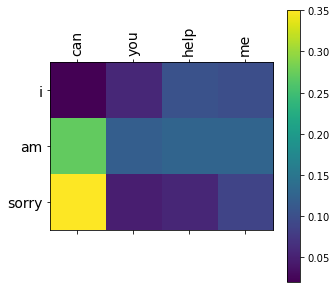

Q8: where is the book
A8 (Epoch 5): i am sorry
Attention weights (first 3 timesteps):
[[0.02469966 0.08380766 0.10586988 0.10215526 0.09712165 0.05682197
  0.04988174 0.05067384 0.05105248 0.05156312 0.05058277 0.04878482
  0.04570235 0.04133938 0.03670977 0.03365787 0.03379883 0.035777  ]
 [0.2685993  0.12403376 0.12503518 0.11641498 0.09468352 0.03463199
  0.02850087 0.0263397  0.02392359 0.02214212 0.02078945 0.01985254
  0.01890909 0.0173302  0.01523715 0.01400223 0.01421158 0.01536275]
 [0.33540428 0.04762001 0.05436115 0.09115629 0.09146072 0.07003394
  0.03903474 0.03330937 0.03004858 0.0280614  0.02634255 0.02500001
  0.02382185 0.0224419  0.02077727 0.01967952 0.02010314 0.0213433 ]]


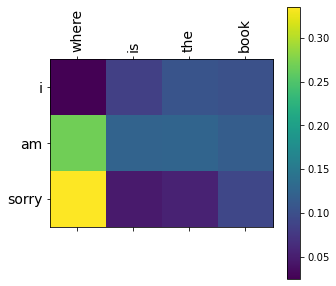

Q9: do you have a problem
A9 (Epoch 5): i am not you
Attention weights (first 3 timesteps):
[[0.0195827  0.03777848 0.12335759 0.11801773 0.11685902 0.02883331
  0.03299733 0.03599722 0.04110784 0.0507926  0.05351778 0.05339217
  0.05245203 0.0502429  0.04716482 0.04502911 0.04549356 0.04738384]
 [0.27068898 0.11751999 0.13219455 0.12554158 0.09930476 0.02625043
  0.02428189 0.02331704 0.02229779 0.02142261 0.02071022 0.01996589
  0.01897405 0.01734184 0.01546607 0.01445443 0.01465223 0.01561567]
 [0.3434416  0.04899803 0.05434906 0.08535431 0.08108249 0.05633661
  0.04424324 0.03934677 0.03337516 0.029878   0.02722505 0.02513261
  0.02375571 0.02262182 0.02143826 0.02063747 0.02093637 0.02184746]]


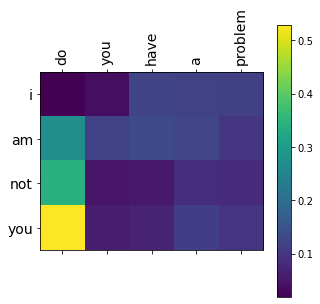

Q10: what is your name
A10 (Epoch 5): i am not
Attention weights (first 3 timesteps):
[[0.0220955  0.03218582 0.09589118 0.09519994 0.07337284 0.07418423
  0.08293627 0.08622576 0.07847142 0.0683094  0.05914167 0.0503078
  0.0423926  0.03460425 0.0279775  0.02439896 0.02474984 0.02755499]
 [0.30490747 0.13195577 0.1202427  0.1006833  0.08863671 0.02968584
  0.02623217 0.02483995 0.0226075  0.02105764 0.02001463 0.01927734
  0.0184124  0.0167857  0.01446698 0.01298319 0.01304681 0.01416391]
 [0.34319997 0.04578038 0.05692354 0.08394995 0.08165283 0.06643166
  0.04859503 0.04255171 0.03455091 0.03011601 0.02675332 0.02423479
  0.02242429 0.02057227 0.0184346  0.01715    0.01761228 0.01906645]]


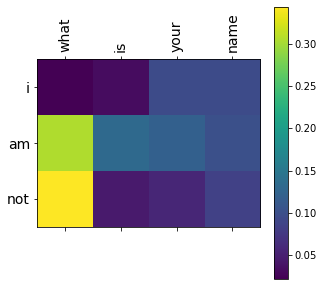


========== EPOCH 50 ==========

Loading glove...
GloVe 50 loaded!
Q1: hi
A1 (Epoch 50): hi
Attention weights (first 3 timesteps):
[[0.01753012 0.03459117 0.10061888 0.12193686 0.11325471 0.05069829
  0.05582314 0.05743412 0.05839446 0.05982715 0.05880443 0.0544346
  0.04865843 0.04156819 0.03397703 0.02943868 0.02974084 0.03326886]
 [0.29365513 0.11030356 0.1310567  0.1260961  0.08200942 0.0284106
  0.02794278 0.02666003 0.02421375 0.0224393  0.02062302 0.01883159
  0.01728862 0.01584963 0.01435329 0.01315778 0.01310121 0.01400743]]


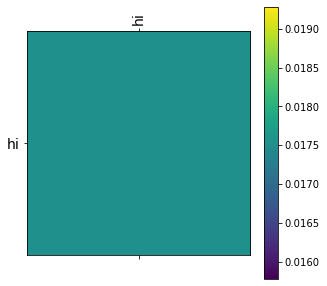

Q2: how are you
A2 (Epoch 50): i am sorry
Attention weights (first 3 timesteps):
[[0.02601316 0.04117209 0.11094709 0.08541304 0.0860616  0.06256083
  0.07250985 0.07078262 0.06479268 0.06076467 0.05693502 0.05143886
  0.04503802 0.03837844 0.03283558 0.03008172 0.03082394 0.03345078]
 [0.30367664 0.12750968 0.1264689  0.10204054 0.08448976 0.02600427
  0.02323799 0.02272428 0.02192755 0.02125372 0.02058591 0.01994452
  0.01924099 0.01806734 0.01640782 0.01523932 0.01517143 0.01600931]
 [0.35842124 0.04802373 0.05339134 0.08309811 0.08451448 0.06007154
  0.03610049 0.03286159 0.03023578 0.02876195 0.02676418 0.02475891
  0.02346864 0.0225821  0.02183691 0.02138386 0.02158341 0.02214178]]


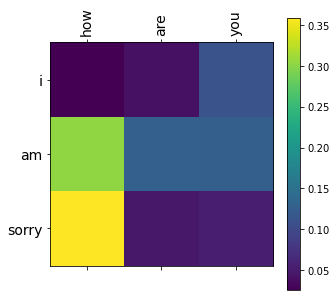

Q3: what are you doing
A3 (Epoch 50): i am sorry
Attention weights (first 3 timesteps):
[[0.02377643 0.05763619 0.11617963 0.09140253 0.08618847 0.04814132
  0.06591556 0.0700595  0.06618226 0.0618115  0.05751616 0.05138221
  0.0443491  0.0373444  0.03166049 0.02885119 0.02955814 0.03204482]
 [0.28403524 0.11760338 0.12353417 0.11354873 0.10205346 0.02832658
  0.02328908 0.02222187 0.02130801 0.02059629 0.01992822 0.01937509
  0.01890455 0.01824497 0.01723641 0.01635194 0.0163526  0.01708942]
 [0.36305442 0.05058085 0.05548718 0.08613173 0.08582048 0.05438875
  0.03346552 0.03114841 0.02913603 0.02813171 0.02661888 0.02484642
  0.02352215 0.022476   0.02148098 0.02082214 0.02105216 0.02183616]]


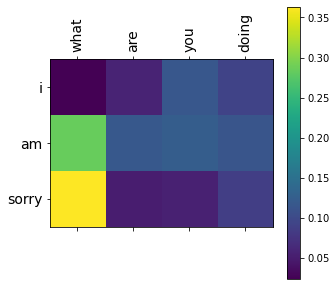

Q4: what is your favorite restaurant
A4 (Epoch 50): i am not
Attention weights (first 3 timesteps):
[[0.02872713 0.04451985 0.10499792 0.08301822 0.09783822 0.04459319
  0.07248467 0.07408113 0.06822474 0.06195486 0.05619286 0.05156616
  0.04644694 0.04011996 0.03376983 0.02971703 0.02953552 0.03221172]
 [0.2932475  0.12211534 0.12419321 0.11738724 0.09935503 0.0269588
  0.02429382 0.02284797 0.02171288 0.02051872 0.01941354 0.01849036
  0.0173862  0.01580144 0.01440355 0.0137223  0.01380421 0.01434786]
 [0.35634422 0.04385984 0.05329752 0.08717996 0.08693752 0.05502998
  0.04263107 0.03892716 0.0347218  0.02984228 0.02660325 0.02481209
  0.02336279 0.02141557 0.01907576 0.01790806 0.01837573 0.01967547]]


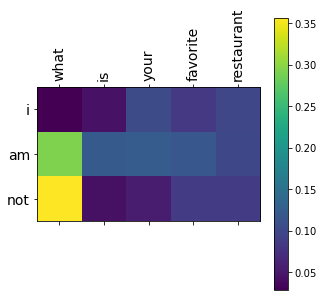

Q5: how is the weather
A5 (Epoch 50): i am not going to do
Attention weights (first 3 timesteps):
[[0.03166026 0.10413343 0.0900406  0.07028089 0.05317337 0.07073625
  0.07241399 0.06980222 0.06392097 0.06105201 0.05856551 0.0533065
  0.04610258 0.03815549 0.03138687 0.02759646 0.02756116 0.03011148]
 [0.3075136  0.12613186 0.12546507 0.12089031 0.06799879 0.02848828
  0.02472241 0.02358768 0.02226321 0.02136533 0.02054703 0.01951221
  0.01809186 0.01628488 0.01481351 0.01396509 0.0139065  0.01445248]
 [0.34443384 0.04580323 0.0573959  0.09053303 0.07676026 0.05949862
  0.04052456 0.03648604 0.03208381 0.0294585  0.02721319 0.02555458
  0.02448385 0.02342007 0.02201871 0.02093887 0.02116424 0.02222868]]


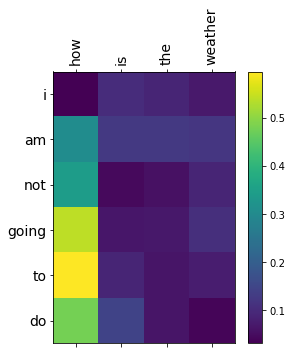

Q6: do you want to go out
A6 (Epoch 50): i am not going to do
Attention weights (first 3 timesteps):
[[0.02055229 0.04423208 0.11530844 0.11181621 0.10297477 0.03800837
  0.0479291  0.03662236 0.03929148 0.05042557 0.05661935 0.05664647
  0.05417702 0.04989155 0.0448372  0.0418002  0.04282936 0.04603814]
 [0.2753139  0.11701366 0.12630685 0.12594    0.09965772 0.02944736
  0.02393752 0.02251335 0.02164089 0.02097927 0.02036195 0.01972148
  0.01877062 0.01718492 0.01556127 0.01477304 0.01500545 0.0158707 ]
 [0.3283135  0.04087804 0.05804137 0.08809378 0.0861048  0.06868724
  0.03924048 0.04119252 0.03473466 0.03021128 0.02752206 0.02555098
  0.02408841 0.02270065 0.02122287 0.0203504  0.02088937 0.02217766]]


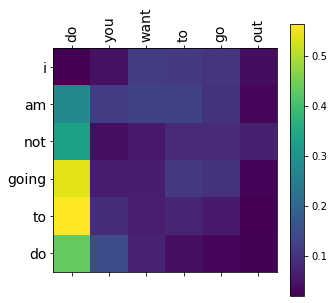

Q7: can you help me
A7 (Epoch 50): i am sorry
Attention weights (first 3 timesteps):
[[0.01838098 0.0580828  0.11601729 0.104192   0.09118068 0.03375401
  0.03757754 0.0379505  0.04353986 0.05432966 0.05847496 0.05739407
  0.05506726 0.05142289 0.04698676 0.04407183 0.04459704 0.04697986]
 [0.26611924 0.11966416 0.1312345  0.12827297 0.09577927 0.02714543
  0.02363786 0.02282332 0.02215993 0.02163393 0.02105469 0.02039573
  0.01948816 0.01792797 0.0160641  0.01502883 0.01527005 0.0162999 ]
 [0.33793414 0.04888044 0.05932363 0.09133237 0.08877447 0.05866314
  0.03480107 0.0316674  0.0290005  0.02777686 0.02671489 0.02579973
  0.02500434 0.02404281 0.02278535 0.02190752 0.02228182 0.02330958]]


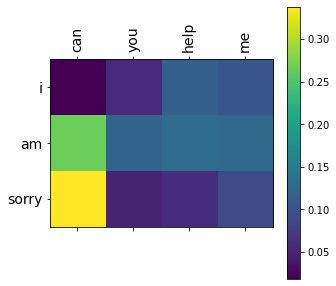

Q8: where is the book
A8 (Epoch 50): i am not going to be
Attention weights (first 3 timesteps):
[[0.02330605 0.08491389 0.11123423 0.10444667 0.09420505 0.05184567
  0.04944121 0.05057507 0.0500473  0.05051414 0.05073604 0.04924075
  0.04595481 0.04153311 0.03699671 0.03411165 0.03442086 0.03647681]
 [0.25921816 0.13350968 0.12500042 0.11951512 0.09943876 0.03016989
  0.02664948 0.02484232 0.0227822  0.0214796  0.02037134 0.01952497
  0.01870442 0.01741443 0.01581543 0.01486833 0.01493734 0.01575815]
 [0.3372625  0.04576033 0.05836625 0.09017933 0.08658347 0.06546493
  0.04209838 0.03614241 0.03248441 0.03036168 0.02771082 0.02530955
  0.02349187 0.02161416 0.01961509 0.01857438 0.01890409 0.02007627]]


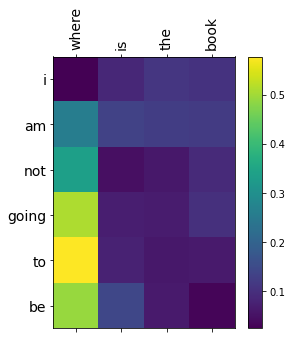

Q9: do you have a problem
A9 (Epoch 50): i am not going to do
Attention weights (first 3 timesteps):
[[0.02076045 0.03240834 0.11238162 0.11935405 0.11549122 0.03488559
  0.03529096 0.03784354 0.04322693 0.05163038 0.05354965 0.05355149
  0.05265241 0.0504717  0.04743196 0.04533877 0.04588844 0.04784247]
 [0.27209643 0.12425447 0.13559765 0.12291302 0.08758149 0.02741174
  0.02453913 0.02346888 0.02234083 0.02141942 0.02064566 0.01986307
  0.01876327 0.01718373 0.0157574  0.0150269  0.01520386 0.01593305]
 [0.36567858 0.04721942 0.05445268 0.08555472 0.08273227 0.0537676
  0.03839271 0.0343683  0.02957583 0.02699858 0.02535885 0.02427544
  0.02353152 0.02274727 0.0216972  0.02083612 0.02097837 0.02183457]]


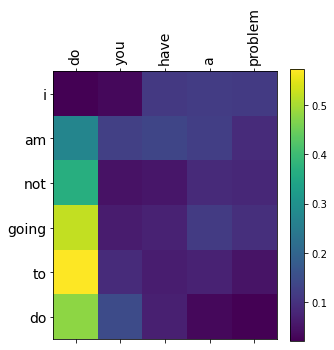

Q10: what is your name
A10 (Epoch 50): i am not going to be a good idea
Attention weights (first 3 timesteps):
[[0.0256715  0.03385499 0.09213261 0.09096532 0.06036502 0.07758979
  0.08559918 0.08619045 0.07892177 0.06846962 0.05961443 0.05128714
  0.04373847 0.03610009 0.02942865 0.02569271 0.02586811 0.02851017]
 [0.28595614 0.1344505  0.12440711 0.10280696 0.08844259 0.03260088
  0.02872883 0.02659477 0.02437622 0.02242577 0.02090555 0.01965551
  0.01822201 0.01618    0.01426146 0.01313146 0.01305883 0.01379539]
 [0.35056475 0.04416464 0.05250396 0.08704536 0.0866946  0.06333005
  0.04322616 0.03879138 0.0331911  0.02874945 0.026343   0.02483358
  0.02350345 0.02164884 0.01929719 0.01802656 0.01840961 0.01967618]]


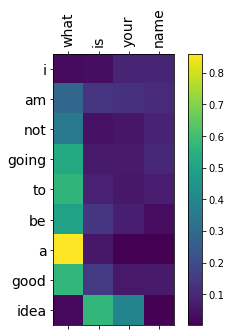


========== EPOCH 100 ==========

Loading glove...
GloVe 50 loaded!
Q1: hi
A1 (Epoch 100): hi
Attention weights (first 3 timesteps):
[[0.01498911 0.03156234 0.1239439  0.13684136 0.12253706 0.04221284
  0.04792647 0.05132402 0.0519308  0.05679503 0.05917927 0.05544616
  0.04864241 0.03999064 0.03135975 0.02681973 0.02740609 0.03109304]
 [0.28316885 0.12930904 0.12543368 0.1198754  0.09203164 0.03111673
  0.02810176 0.02564293 0.02323066 0.02148858 0.01948439 0.0176379
  0.01625376 0.01494901 0.01354273 0.01253263 0.01264842 0.0135519 ]]


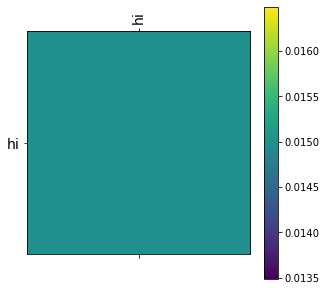

Q2: how are you
A2 (Epoch 100): i am not going to do
Attention weights (first 3 timesteps):
[[0.02594233 0.05765215 0.11727705 0.08763062 0.08472902 0.06112985
  0.07043521 0.06566586 0.05886295 0.05577136 0.05352423 0.04963512
  0.04437179 0.03842901 0.03324434 0.03063898 0.03134409 0.03371599]
 [0.30463043 0.12540792 0.12276179 0.10543199 0.08977317 0.02781759
  0.0230707  0.02210025 0.02114536 0.02035493 0.01962951 0.01902847
  0.01844465 0.01752938 0.01617472 0.01520216 0.01530081 0.01619617]
 [0.37933517 0.05241522 0.05291283 0.08162586 0.08144081 0.05323667
  0.03151264 0.02970735 0.02849174 0.02787295 0.0265932  0.02469948
  0.02314626 0.02211658 0.02140328 0.02093744 0.02103226 0.02152027]]


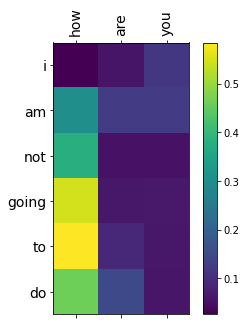

Q3: what are you doing
A3 (Epoch 100): i am not
Attention weights (first 3 timesteps):
[[0.0245593  0.04119063 0.11584745 0.09728761 0.09224334 0.04344321
  0.06098703 0.06758945 0.0642463  0.06088347 0.0575518  0.05284858
  0.04697698 0.04038723 0.03464182 0.03173164 0.032485   0.03509921]
 [0.27455902 0.1216414  0.12405501 0.11804943 0.10645021 0.0290023
  0.02457522 0.02297634 0.02187864 0.0211037  0.02027956 0.01947185
  0.01857595 0.01715081 0.01552878 0.01461604 0.01466668 0.01541905]
 [0.38620552 0.05159882 0.05120919 0.07652096 0.0746008  0.04744131
  0.03652991 0.03367881 0.03091715 0.02962777 0.02798314 0.02561773
  0.02350501 0.02192513 0.02077564 0.02023273 0.02051399 0.02111634]]


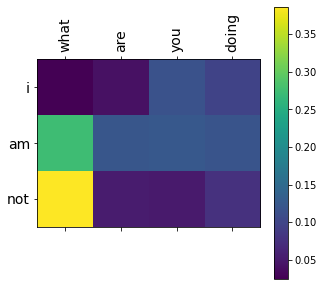

Q4: what is your favorite restaurant
A4 (Epoch 100): i am not
Attention weights (first 3 timesteps):
[[0.02676929 0.05472299 0.10765412 0.09370402 0.0929592  0.04464691
  0.06955673 0.07073933 0.06633491 0.06161785 0.05637529 0.05095201
  0.0450073  0.03852241 0.03241896 0.02857778 0.0284471  0.03099386]
 [0.33014852 0.11086278 0.11213513 0.11708526 0.09549516 0.02808615
  0.02377979 0.02186372 0.02046886 0.01944236 0.01863917 0.01794852
  0.01687185 0.01503249 0.01323686 0.0124571  0.01279095 0.01365532]
 [0.3526085  0.04373216 0.05478801 0.08687381 0.0834887  0.05068774
  0.04215391 0.03924832 0.03513985 0.03070294 0.02732079 0.0253455
  0.0239284  0.02243385 0.02063143 0.01945194 0.019968   0.02149613]]


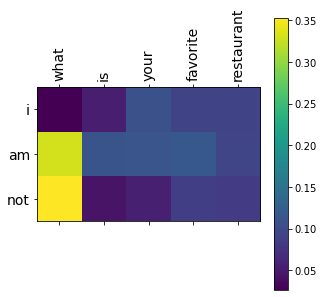

Q5: how is the weather
A5 (Epoch 100): i am not going to
Attention weights (first 3 timesteps):
[[0.02665878 0.08955077 0.10340133 0.08207943 0.06820737 0.06702758
  0.07101012 0.06846884 0.06109523 0.05779935 0.0556637  0.05124256
  0.04501358 0.03767502 0.03106969 0.02728228 0.02719635 0.02955803]
 [0.3260051  0.14928363 0.12225076 0.09280819 0.06157997 0.02990648
  0.026799   0.02530522 0.02359727 0.02249898 0.02135506 0.02001197
  0.0181273  0.01519288 0.01232659 0.01072302 0.01062027 0.01160829]
 [0.4202568  0.05358315 0.04965234 0.07221934 0.06103394 0.04531602
  0.03260282 0.0307437  0.02905956 0.02817979 0.02698027 0.02504642
  0.02305946 0.02149037 0.02046874 0.0198967  0.01993952 0.02047112]]


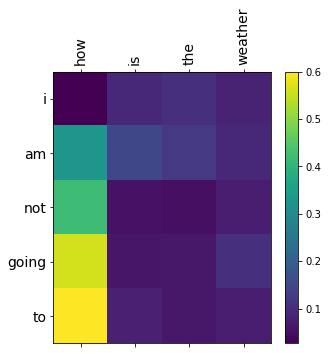

Q6: do you want to go out
A6 (Epoch 100): i am not going to do
Attention weights (first 3 timesteps):
[[0.01981801 0.05099035 0.10281529 0.1073239  0.09862712 0.04110795
  0.04821605 0.0365069  0.0391255  0.05094855 0.05779264 0.05801042
  0.0555816  0.0513889  0.04642211 0.04340324 0.04438737 0.04753403]
 [0.2734828  0.11879977 0.12426715 0.12728712 0.09603427 0.03194806
  0.0250043  0.02345865 0.02259855 0.02182637 0.02097172 0.02013817
  0.01901784 0.01714113 0.01501603 0.01380708 0.01403224 0.01516871]
 [0.33512512 0.04488463 0.05340461 0.08691501 0.08585542 0.06693687
  0.0374008  0.03968837 0.03391659 0.03023873 0.02760314 0.0255412
  0.02410925 0.0228392  0.02149977 0.0206779  0.02112692 0.02223651]]


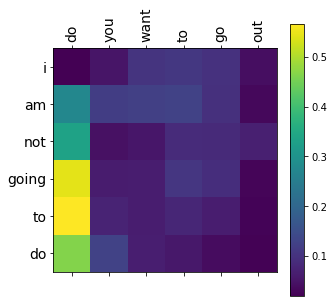

Q7: can you help me
A7 (Epoch 100): i am not going to
Attention weights (first 3 timesteps):
[[0.01876424 0.06066642 0.11923533 0.10329848 0.09644909 0.03589858
  0.0358539  0.03565041 0.04042928 0.05134345 0.05748045 0.05709593
  0.0548408  0.05115353 0.04671068 0.04382977 0.04441558 0.04688412]
 [0.27220365 0.11684311 0.12746155 0.12564543 0.10509569 0.02607868
  0.02300646 0.02218311 0.02131673 0.02068608 0.02012508 0.01967437
  0.01908933 0.01794378 0.01622861 0.01503394 0.01515064 0.01623375]
 [0.33487308 0.04670287 0.05510421 0.08948119 0.08813257 0.06355328
  0.03850462 0.03456539 0.03062364 0.02840539 0.02666511 0.02544238
  0.0245913  0.02369831 0.02258602 0.02181871 0.02216903 0.02308281]]


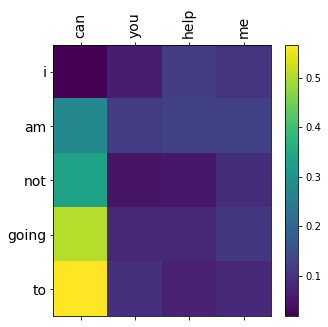

Q8: where is the book
A8 (Epoch 100): i am sorry
Attention weights (first 3 timesteps):
[[0.02330528 0.08883159 0.10725746 0.10358638 0.09691328 0.06005488
  0.05007907 0.05007238 0.04897089 0.04949733 0.04960062 0.04842345
  0.04545674 0.04090867 0.03592887 0.03277476 0.0330933  0.03524511]
 [0.30688837 0.1352498  0.10886838 0.10736284 0.09374968 0.03264989
  0.02769285 0.0258737  0.02150121 0.01917998 0.01821693 0.01752082
  0.01674226 0.01547018 0.01377527 0.01273484 0.01282795 0.01369503]
 [0.33035    0.04793707 0.05668279 0.09042936 0.08953553 0.06479172
  0.04163995 0.0357271  0.03208989 0.02979633 0.02765093 0.0258999
  0.02438385 0.0225971  0.0204721  0.0192511  0.01969812 0.02106719]]


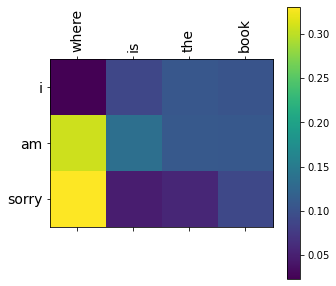

Q9: do you have a problem
A9 (Epoch 100): i am sorry
Attention weights (first 3 timesteps):
[[0.01889043 0.04187109 0.12768434 0.1154855  0.11805741 0.03051767
  0.03250857 0.03590192 0.04122249 0.04925469 0.05265091 0.05275656
  0.05195727 0.04981732 0.04660263 0.04415498 0.04439329 0.04627297]
 [0.2691338  0.12176803 0.13866167 0.12271558 0.09156922 0.02540633
  0.02533954 0.02475425 0.02368392 0.02247843 0.021457   0.02035888
  0.01880161 0.01661212 0.01470495 0.01383172 0.01396364 0.01475935]
 [0.3541054  0.04912787 0.0537273  0.0821448  0.08015168 0.04922485
  0.04295442 0.04044788 0.03532411 0.03083787 0.02784514 0.02550393
  0.02386646 0.02248762 0.02103169 0.01997494 0.02012039 0.02112367]]


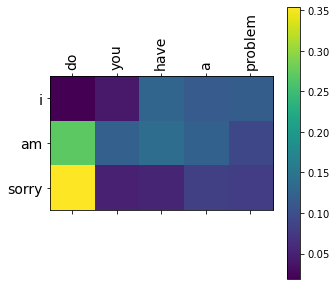

Q10: what is your name
A10 (Epoch 100): i am you
Attention weights (first 3 timesteps):
[[0.02208337 0.02202397 0.08975712 0.09671095 0.06926282 0.07408258
  0.08425952 0.08672339 0.0805181  0.07015041 0.06148999 0.05303256
  0.0449758  0.03685241 0.02949962 0.0252275  0.02527566 0.02807426]
 [0.29001436 0.13596667 0.13295184 0.11200922 0.095999   0.02545691
  0.02612904 0.02548878 0.02403651 0.0227003  0.02141308 0.01956933
  0.01693798 0.01377358 0.01059679 0.00856159 0.00848172 0.00991334]
 [0.34826118 0.045502   0.05498292 0.08125515 0.08234996 0.0642558
  0.04615672 0.04162982 0.03414859 0.02961471 0.02671132 0.02469149
  0.02322252 0.02146789 0.01920087 0.01794531 0.01854931 0.02005437]]


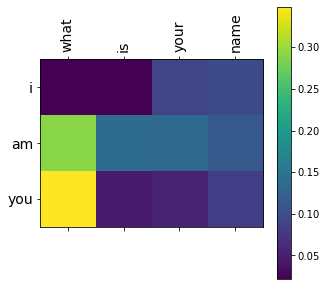

In [51]:
evaluate_epochs(questions, Encoder, Decoder)